# Analytics

#### Date: 2020/05

#### SUMMARY:

- This notebook represents the project quality analysis of the date exposed right above. 

### TEAM:

##### Semester: 2020/02
##### Professor: Hilmer Neri

##### Members:

- André Pinto
- Leonardo Medeiros
- Lieverton Silva
- Welison Regis

In [1]:
pip install pandas seaborn openpyxl

Note: you may need to restart the kernel to use updated packages.


### LIBRARIES

In [2]:
# Deal with data
import pandas as pd
import numpy as np
import json
from glob import glob
import os

# Deal with API request
import urllib3
from urllib3 import request

# Deal with visualization
import seaborn as sns
import matplotlib.pyplot as plt

### GRAPH SETTINGS

In [3]:
%config InlineBackend.figure_format ='retina'
sns.set(font_scale=1.5)
sns.set_style('darkgrid',
              {'xtick.bottom' : True,
               'ytick.left': True,
               'grid.linestyle':'--',
               'font.monospace': ['Computer Modern Typewriter'],
               'axes.edgecolor' : 'white'})

### DATAFRAME SETTINGS

In [4]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

### SonarCloud

##### repo names, lenguage and path to the folder with all your jsons

In [5]:
#insert the repo names and used lenguages

repos = ['2020_2-Projeto-Kokama-Traducao', 
         '2020_2-Projeto-Kokama-Usuario', 
         '2020_2-Projeto-Kokama-Ensino', 
         '2020_2-Projeto-Kokama-Front-end']
language = [['2020_2-Projeto-Kokama-Traducao', 'py'], 
            ['2020_2-Projeto-Kokama-Usuario', 'py'], 
            ['2020_2-Projeto-Kokama-Ensino', 'py'], 
            ['2020_2-Projeto-Kokama-Front-end', 'ts']]

repos_lenguage = {}

for item in language:
    repos_lenguage[f"{item[0]}"] = item[1]
    

In [6]:
repos_lenguage

{'2020_2-Projeto-Kokama-Traducao': 'py',
 '2020_2-Projeto-Kokama-Usuario': 'py',
 '2020_2-Projeto-Kokama-Ensino': 'py',
 '2020_2-Projeto-Kokama-Front-end': 'ts'}

In [7]:
jsons = glob('analytics-raw-data/*.json') # add the path here

In [8]:
def read_json(json_path):
    
    with open(json_path) as json_file:
        json_obj = json.load(json_file)
        
    return json_obj

def create_base_component_df(json_list):
    
    df = pd.DataFrame()

    for i in json_list:

        base_component = read_json(i)

        base_component_data = base_component['baseComponent']['measures']

        base_component_df = pd.DataFrame(base_component_data)

        base_component_df['filename'] = os.path.basename(i)

        df = df.append(base_component_df, ignore_index=True)
        
    aux_df = df['filename'].str.split(r"fga-eps-mds-(.*?)-(\d+-\d+-\d+).json", expand=True)
    
    df['repository'] = aux_df[1]
    
    df['version'] = aux_df[2]
    
    df = df.sort_values(by=['repository', 'version'])
        
    return df, repos

#### Create base component dataframe and repos list

In [9]:
base_component_df, repos = create_base_component_df(jsons)

In [10]:
base_component_df.head(10)

,metric,value,bestValue,filename,repository,version
24,complexity,37,NaN,fga-eps-mds-2020_2-Projeto-Kokama-Ensino-14-04...,2020_2-Projeto-Kokama-Ensino,14-04-2021
25,duplicated_lines_density,0.0,True,fga-eps-mds-2020_2-Projeto-Kokama-Ensino-14-04...,2020_2-Projeto-Kokama-Ensino,14-04-2021
26,functions,15,NaN,fga-eps-mds-2020_2-Projeto-Kokama-Ensino-14-04...,2020_2-Projeto-Kokama-Ensino,14-04-2021
27,ncloc,726,NaN,fga-eps-mds-2020_2-Projeto-Kokama-Ensino-14-04...,2020_2-Projeto-Kokama-Ensino,14-04-2021
28,reliability_rating,1.0,True,fga-eps-mds-2020_2-Projeto-Kokama-Ensino-14-04...,2020_2-Projeto-Kokama-Ensino,14-04-2021
29,security_rating,1.0,True,fga-eps-mds-2020_2-Projeto-Kokama-Ensino-14-04...,2020_2-Projeto-Kokama-Ensino,14-04-2021
30,comment_lines_density,7.8,False,fga-eps-mds-2020_2-Projeto-Kokama-Ensino-14-04...,2020_2-Projeto-Kokama-Ensino,14-04-2021
31,files,30,NaN,fga-eps-mds-2020_2-Projeto-Kokama-Ensino-14-04...,2020_2-Projeto-Kokama-Ensino,14-04-2021
0,duplicated_lines_density,0.0,True,fga-eps-mds-2020_2-Projeto-Kokama-Ensino-14-05...,2020_2-Projeto-Kokama-Ensino,14-05-2021
1,functions,15,NaN,fga-eps-mds-2020_2-Projeto-Kokama-Ensino-14-05...,2020_2-Projeto-Kokama-Ensino,14-05-2021


#### Create dataframe per file

In [11]:
metric_list = ['files',
               'functions',
               'complexity',
               'comment_lines_density',
               'duplicated_lines_density',
               'coverage',
               'ncloc',
               'security_rating',
               'tests',
               'test_success_density',
               'test_execution_time',
               'reliability_rating']

len(metric_list)

12

In [12]:
def metric_per_file(json):
    
    file_json = []
    
    for component in json['components']:
        if component['qualifier'] == 'FIL':
            file_json.append(component)
            
    return file_json

In [13]:
def generate_file_dataframe_per_release(metric_list, json, language_extension):
    
    df_columns = metric_list
    df = pd.DataFrame(columns = df_columns)
    
    for file in json:
        try:
            if file['language'] == language_extension:
                for measure in file['measures']:
                    df.at[file['path'], measure['metric']] = measure['value']
        except:
            pass
        
    df.reset_index(inplace = True)
    df = df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)

    return df

In [14]:
def create_file_df(json_list):
    
    df = pd.DataFrame()

    for i in json_list:

        file_component = read_json(i)
        file_component_data = metric_per_file(file_component)
        file_name = os.path.basename(i)
               
        file_repository = file_name[12:-16]
        file_lenguage = repos_lenguage[f"{file_repository}"]
        
        file_component_df = generate_file_dataframe_per_release(metric_list, 
                                                                file_component_data,
                                                                language_extension = file_lenguage)
        file_component_df['filename'] = file_name

        df = df.append(file_component_df, ignore_index=True)
        
    # replace TeamName by yours.   
    aux_df = df['filename'].str.split(r"fga-eps-mds-(.*?)-(\d+-\d+-\d+).json", expand=True)
    
    df['repository'] = aux_df[1]
    
    df['version'] = aux_df[2]
    
    df = df.sort_values(by=['repository', 'version'])
        
    return df

In [15]:
file_component_df = create_file_df(jsons)

In [16]:
file_component_df.head(10)

,path,functions,complexity,comment_lines_density,duplicated_lines_density,coverage,ncloc,security_rating,tests,test_success_density,test_execution_time,reliability_rating,filename,repository,version
80,exercise/__init__.py,0,0,NaN,0.0,NaN,0,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Projeto-Kokama-Ensino-14-04...,2020_2-Projeto-Kokama-Ensino,14-04-2021
81,history/__init__.py,0,0,NaN,0.0,NaN,0,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Projeto-Kokama-Ensino-14-04...,2020_2-Projeto-Kokama-Ensino,14-04-2021
82,tests/__init__.py,0,0,NaN,0.0,NaN,0,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Projeto-Kokama-Ensino-14-04...,2020_2-Projeto-Kokama-Ensino,14-04-2021
83,tests/history/__init__.py,0,0,0.0,0.0,NaN,1,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Projeto-Kokama-Ensino-14-04...,2020_2-Projeto-Kokama-Ensino,14-04-2021
84,exercise/admin.py,0,0,0.0,0.0,NaN,5,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Projeto-Kokama-Ensino-14-04...,2020_2-Projeto-Kokama-Ensino,14-04-2021
85,history/admin.py,0,0,0.0,0.0,NaN,3,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Projeto-Kokama-Ensino-14-04...,2020_2-Projeto-Kokama-Ensino,14-04-2021
86,exercise/apps.py,0,0,0.0,0.0,NaN,3,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Projeto-Kokama-Ensino-14-04...,2020_2-Projeto-Kokama-Ensino,14-04-2021
87,history/apps.py,0,0,0.0,0.0,NaN,3,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Projeto-Kokama-Ensino-14-04...,2020_2-Projeto-Kokama-Ensino,14-04-2021
88,learn/asgi.py,0,0,66.7,0.0,NaN,4,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Projeto-Kokama-Ensino-14-04...,2020_2-Projeto-Kokama-Ensino,14-04-2021
89,history/forms.py,0,0,0.0,0.0,NaN,13,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Projeto-Kokama-Ensino-14-04...,2020_2-Projeto-Kokama-Ensino,14-04-2021


In [17]:
file_component_df.to_excel('data/data.xlsx', index = False)

In [18]:
file_component_df.repository.unique()

array(['2020_2-Projeto-Kokama-Ensino', '2020_2-Projeto-Kokama-Front-end',
       '2020_2-Projeto-Kokama-Traducao', '2020_2-Projeto-Kokama-Usuario'],
      dtype=object)

#### Create dataframe per repository

In [19]:
repository_dataframes = {} 

for repository in repos:
    df = file_component_df[file_component_df['repository'] == f"{repository}"]
    df.name = f"{repository}"
    repository_dataframes[f"{repository}"] = df
    
repository_dataframes.keys()

dict_keys(['2020_2-Projeto-Kokama-Traducao', '2020_2-Projeto-Kokama-Usuario', '2020_2-Projeto-Kokama-Ensino', '2020_2-Projeto-Kokama-Front-end'])

In [20]:
repository_dataframes["2020_2-Projeto-Kokama-Front-end"]

,path,functions,complexity,comment_lines_density,duplicated_lines_density,coverage,ncloc,security_rating,tests,test_success_density,test_execution_time,reliability_rating,filename,repository,version
230,projeto-kokama/src/api/Api.ts,0,0,0.0,0.0,NaN,5,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Projeto-Kokama-Front-end-05...,2020_2-Projeto-Kokama-Front-end,05-04-2021
231,projeto-kokama/App.tsx,9,9,4.9,0.0,NaN,98,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Projeto-Kokama-Front-end-05...,2020_2-Projeto-Kokama-Front-end,05-04-2021
232,projeto-kokama/src/assets/Colors.ts,0,0,0.0,0.0,NaN,11,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Projeto-Kokama-Front-end-05...,2020_2-Projeto-Kokama-Front-end,05-04-2021
233,projeto-kokama/src/config/constants.ts,0,0,0.0,0.0,NaN,3,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Projeto-Kokama-Front-end-05...,2020_2-Projeto-Kokama-Front-end,05-04-2021
234,projeto-kokama/src/utils/dictionary.ts,4,9,0.0,0.0,NaN,38,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Projeto-Kokama-Front-end-05...,2020_2-Projeto-Kokama-Front-end,05-04-2021
235,projeto-kokama/src/components/History.tsx,3,5,0.0,0.0,NaN,70,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Projeto-Kokama-Front-end-05...,2020_2-Projeto-Kokama-Front-end,05-04-2021
236,projeto-kokama/src/components/HistoryTitle.tsx,1,4,0.0,0.0,NaN,55,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Projeto-Kokama-Front-end-05...,2020_2-Projeto-Kokama-Front-end,05-04-2021
237,projeto-kokama/src/index.tsx,1,1,0.0,0.0,NaN,16,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Projeto-Kokama-Front-end-05...,2020_2-Projeto-Kokama-Front-end,05-04-2021
238,projeto-kokama/src/screens/Translation/index.tsx,21,42,10.1,0.0,NaN,286,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Projeto-Kokama-Front-end-05...,2020_2-Projeto-Kokama-Front-end,05-04-2021
239,projeto-kokama/src/screens/KokamaStories/index...,3,4,0.0,0.0,NaN,39,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020_2-Projeto-Kokama-Front-end-05...,2020_2-Projeto-Kokama-Front-end,05-04-2021


### Metric calculations

##### COMPLEXITY

In [21]:
def m1(df):
    
    density_non_complex_files = len(df[(df['complexity'].astype(float)/df['functions'].astype(float)) < 10])/len(df)
    
    return density_non_complex_files

##### COMMENTS

In [22]:
def m2(df):
    
    density_comment_files = len(df[(df['comment_lines_density'].astype(float) > 10) & (df['comment_lines_density'].astype(float) < 30)])/len(df)
    
    return density_comment_files

##### DUPLICATIONS

In [23]:
def m3(df):
    
    duplication = len(df[(df['duplicated_lines_density'].astype(float) < 5)])/len(df)
    
    return duplication

In [24]:
def _ncloc(df):
    ncloc = 0
    for each in df['ncloc']:
        ncloc += int(each)
    
    return ncloc

### Calculate m1, m2 and m3 for each repository

In [31]:
def create_metrics_df(df):
    
    version_vec = df['version'].unique()
    
    m1_list = []
    m2_list = []
    m3_list = []
    repository_list = []
    version_list = []
    ncloc_list = []
#     m7_list = []
#     m8_list = []
#     m9_list = []
    
    metrics_df = pd.DataFrame()
    
    for version in version_vec:

        version_df = df[df['version'] == version]

        m1_list.append(m1(version_df))
        m2_list.append(m2(version_df))
        m3_list.append(m3(version_df))
#         m7_list.append(_m7)
#         m8_list.append(_m8)
#         m9_list.append(_m9)
        repository_list.append(version_df['repository'].iloc[0])
        version_list.append(version)
        ncloc_list.append(_ncloc(version_df))
        
    metrics_df = pd.DataFrame({'m1': m1_list,
                               'm2': m2_list,
                               'm3': m3_list,
#                                'm7': m7_list,
#                                'm8': m8_list,
#                                'm9': m9_list,
                               'repository': repository_list, 
                               'version': version_list,
                               'ncloc': ncloc_list})
        
    return metrics_df

In [32]:
repository_metrics = {}

for repository, repo_df in repository_dataframes.items():   
    metrics_df = create_metrics_df(repo_df)
    metrics_df.name = f"{repository}"
    repository_metrics[f"{repository}"] = metrics_df


### Data visualization

- You must do this for each of your repositories

In [33]:
repository_metrics

{'2020_2-Projeto-Kokama-Traducao':          m1        m2   m3                      repository     version  ncloc
 0  0.190476  0.095238  1.0  2020_2-Projeto-Kokama-Traducao  05-04-2021    465
 1  0.285714  0.142857  1.0  2020_2-Projeto-Kokama-Traducao  06-04-2021    308
 2  0.285714  0.142857  1.0  2020_2-Projeto-Kokama-Traducao  14-05-2021    330
 3  0.173913  0.086957  1.0  2020_2-Projeto-Kokama-Traducao  23-03-2021    336,
 '2020_2-Projeto-Kokama-Usuario':          m1        m2   m3                     repository     version  ncloc
 0  0.200000  0.080000  1.0  2020_2-Projeto-Kokama-Usuario  14-05-2021    570
 1  0.200000  0.080000  1.0  2020_2-Projeto-Kokama-Usuario  15-05-2021    531
 2  0.304348  0.130435  1.0  2020_2-Projeto-Kokama-Usuario  16-05-2021    687
 3  0.000000  0.000000  1.0  2020_2-Projeto-Kokama-Usuario  17-04-2021     24,
 '2020_2-Projeto-Kokama-Ensino':          m1        m2   m3                    repository     version  ncloc
 0  0.230769  0.076923  1.0  2020_2-P

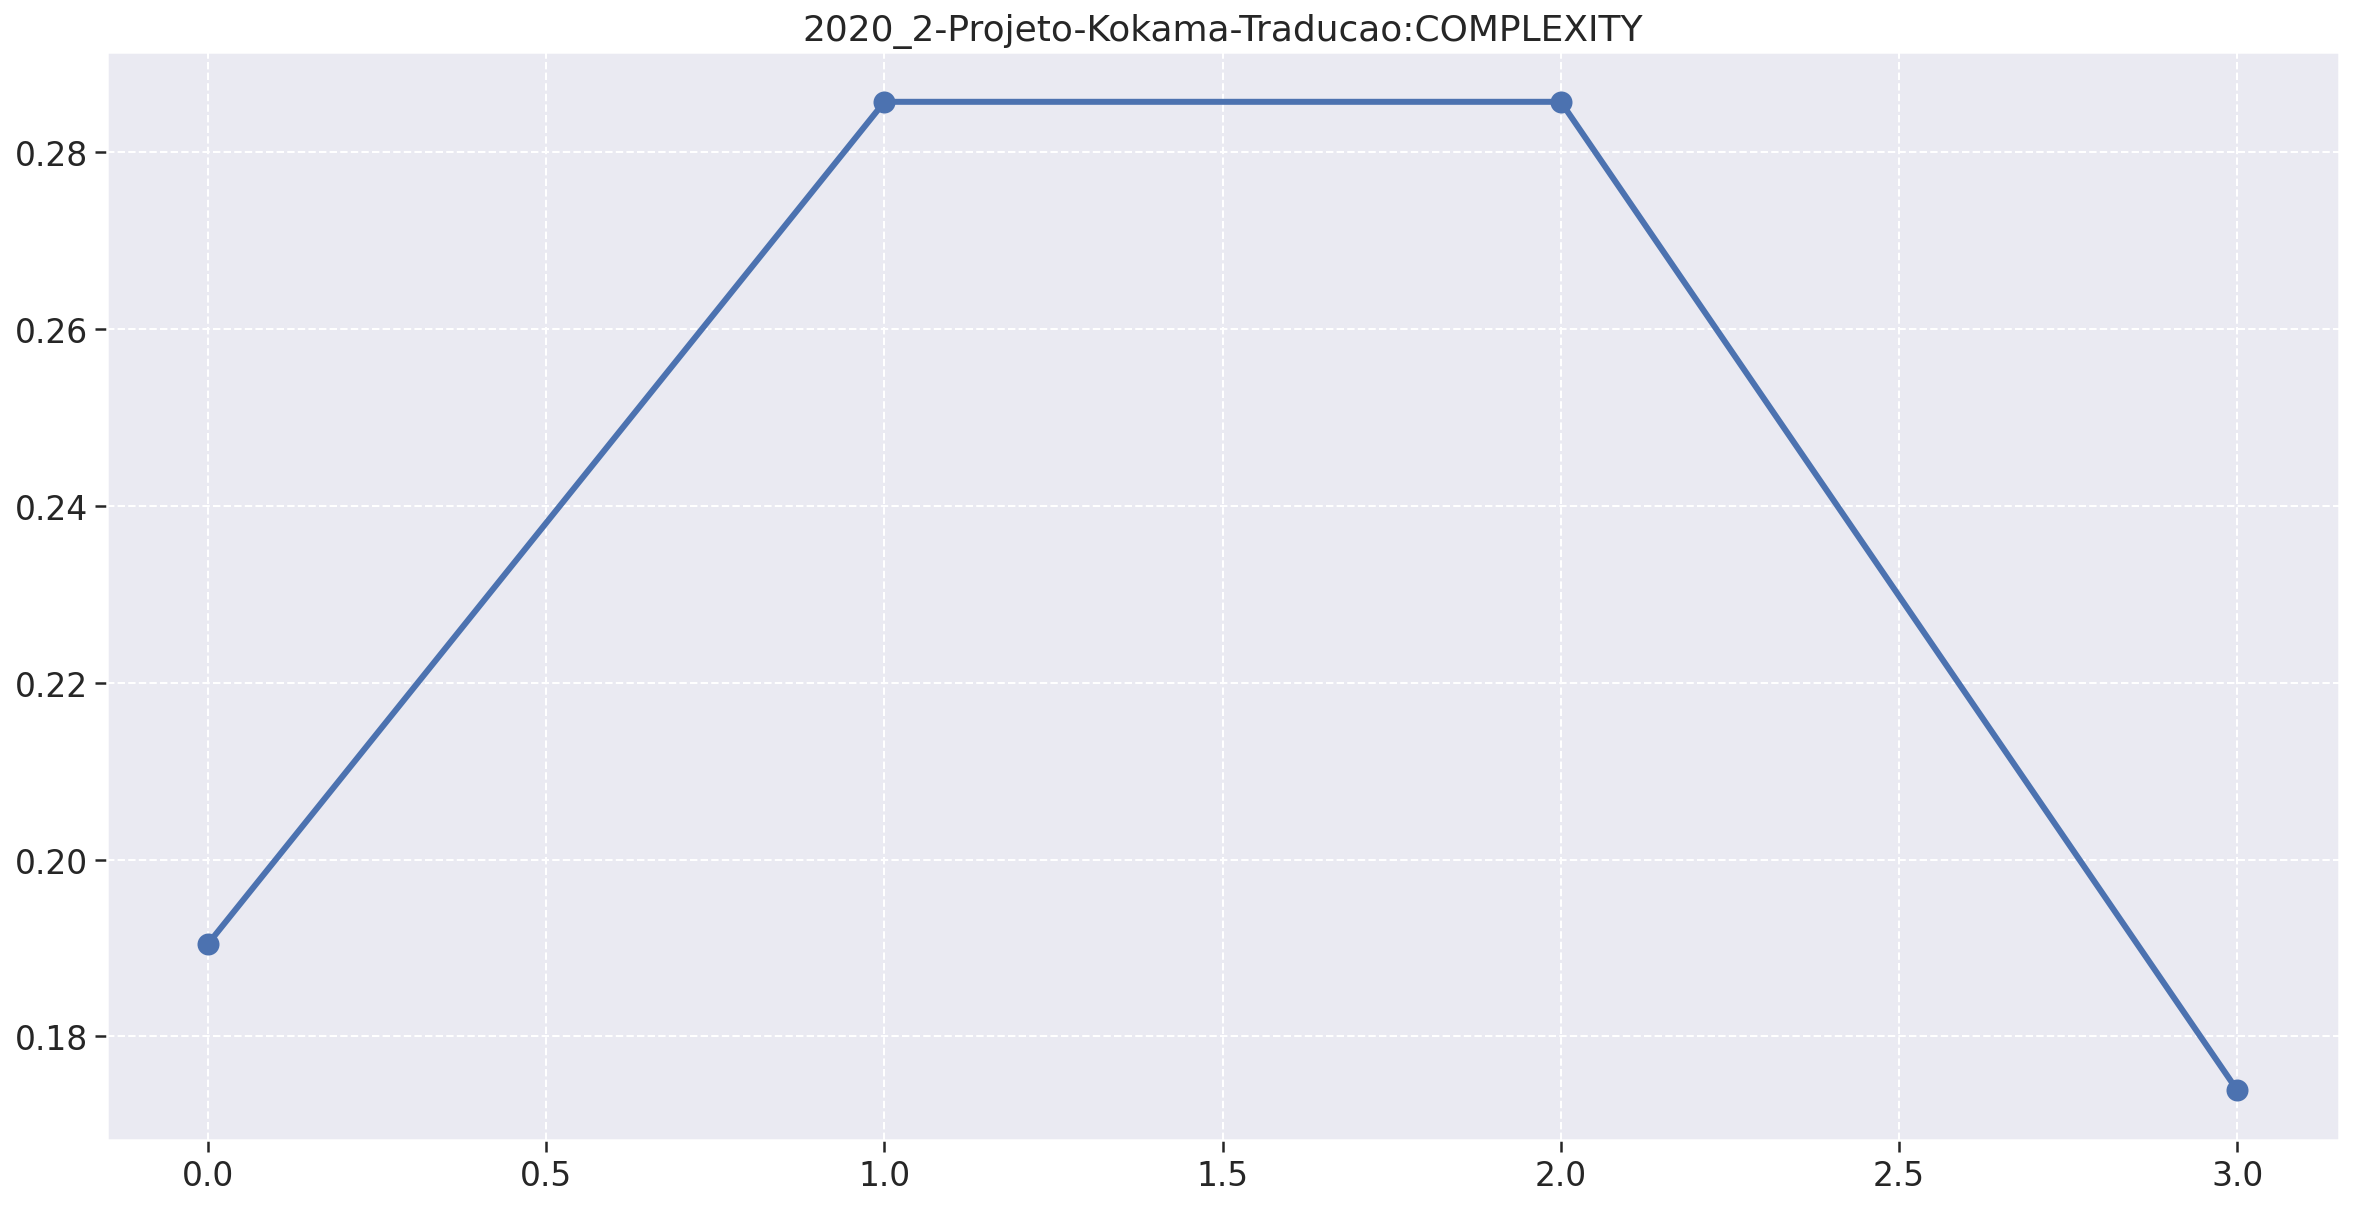

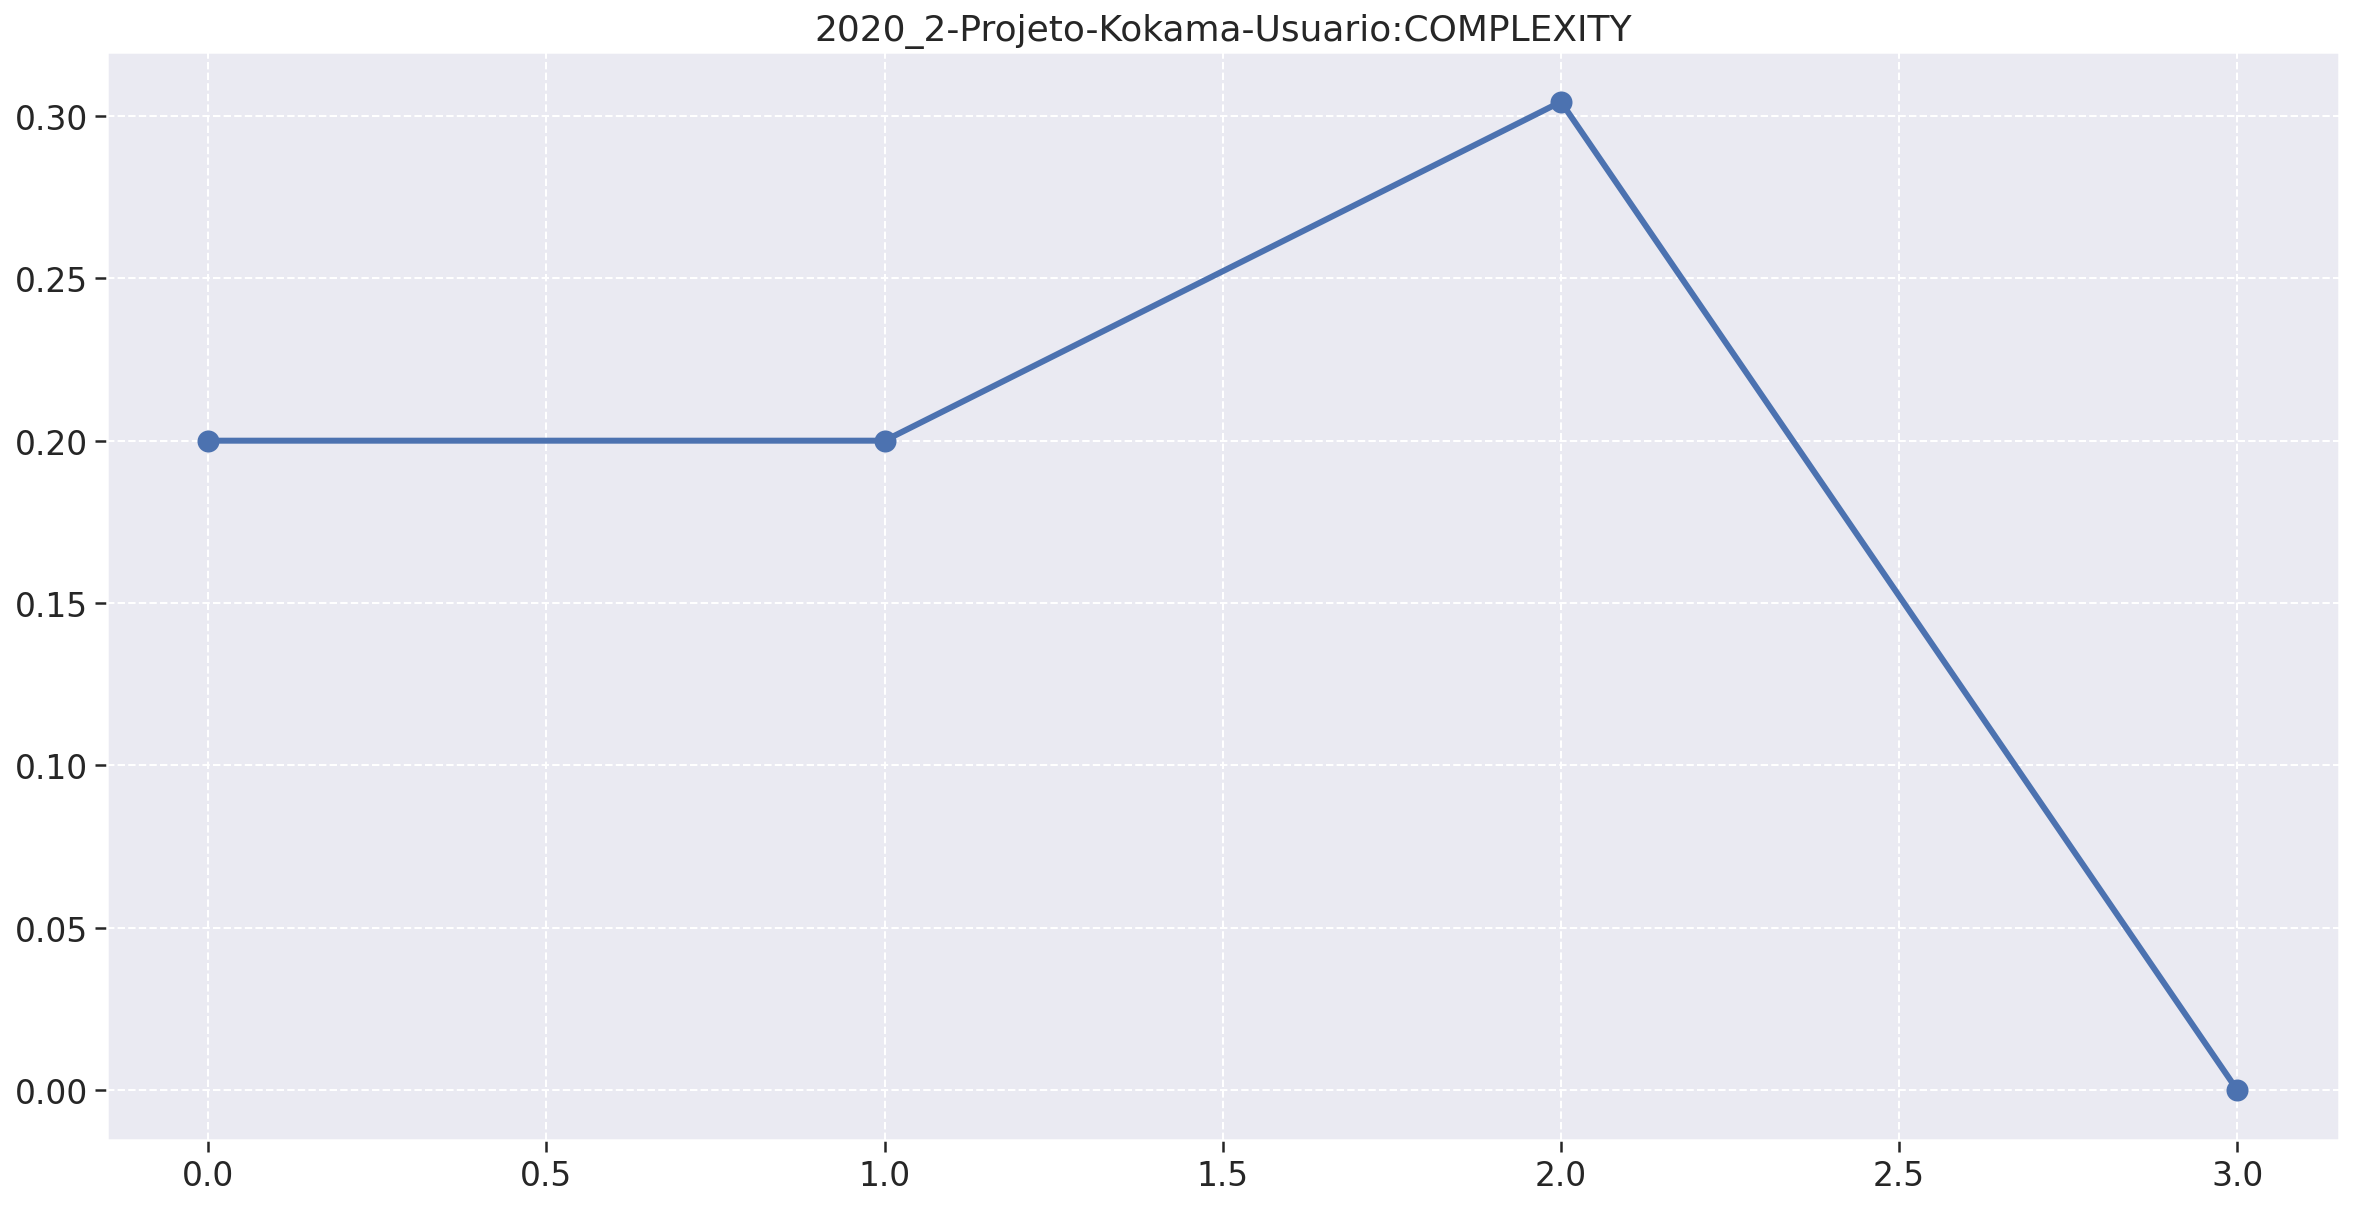

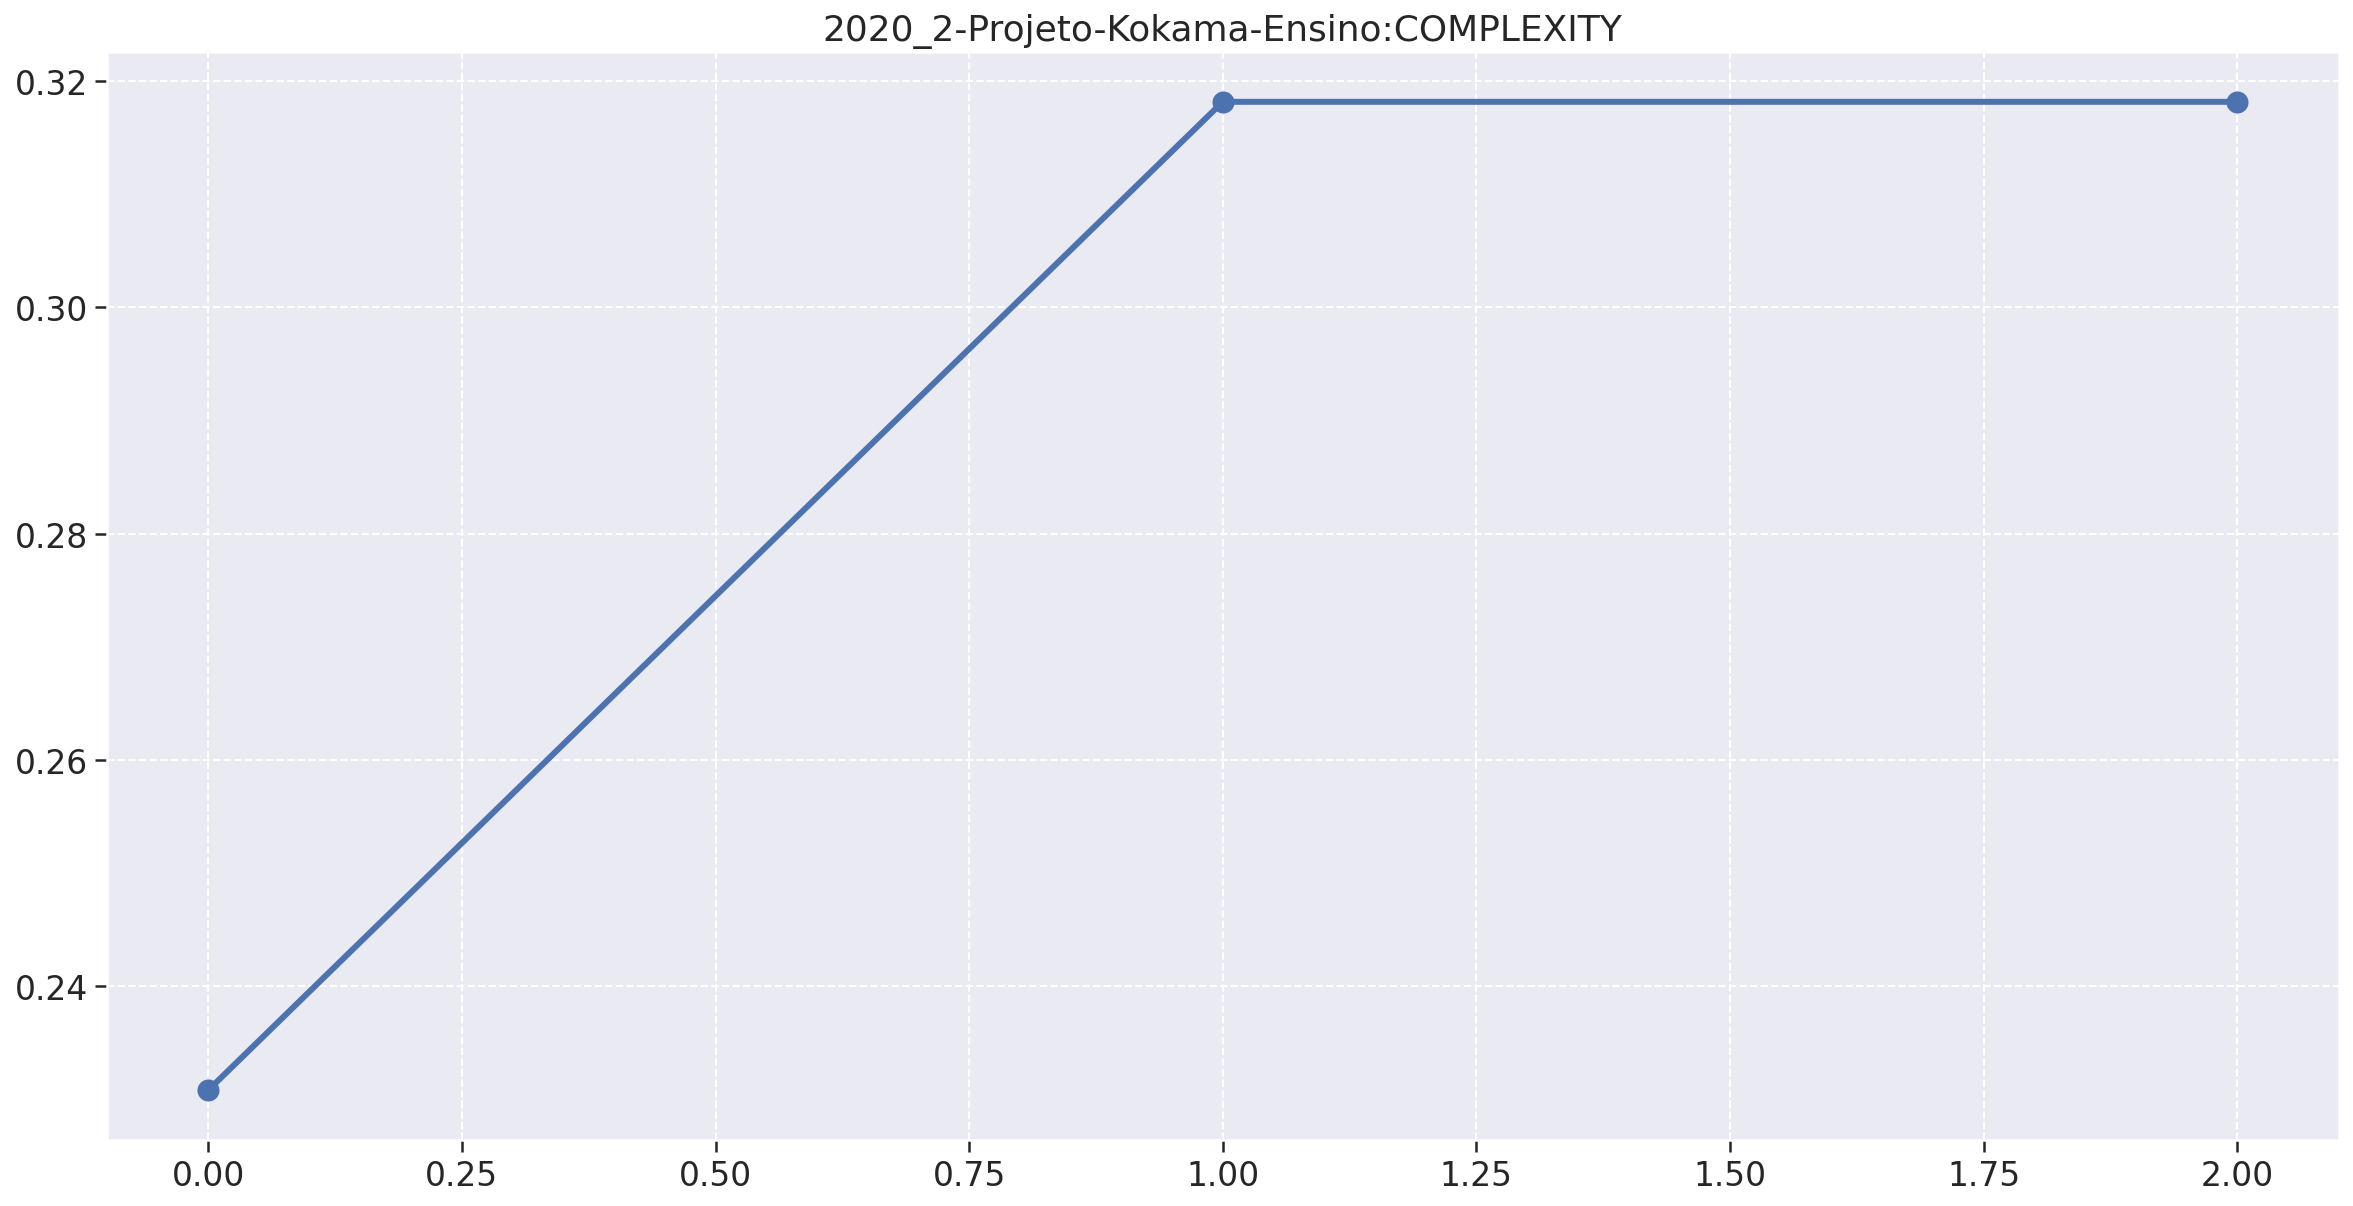

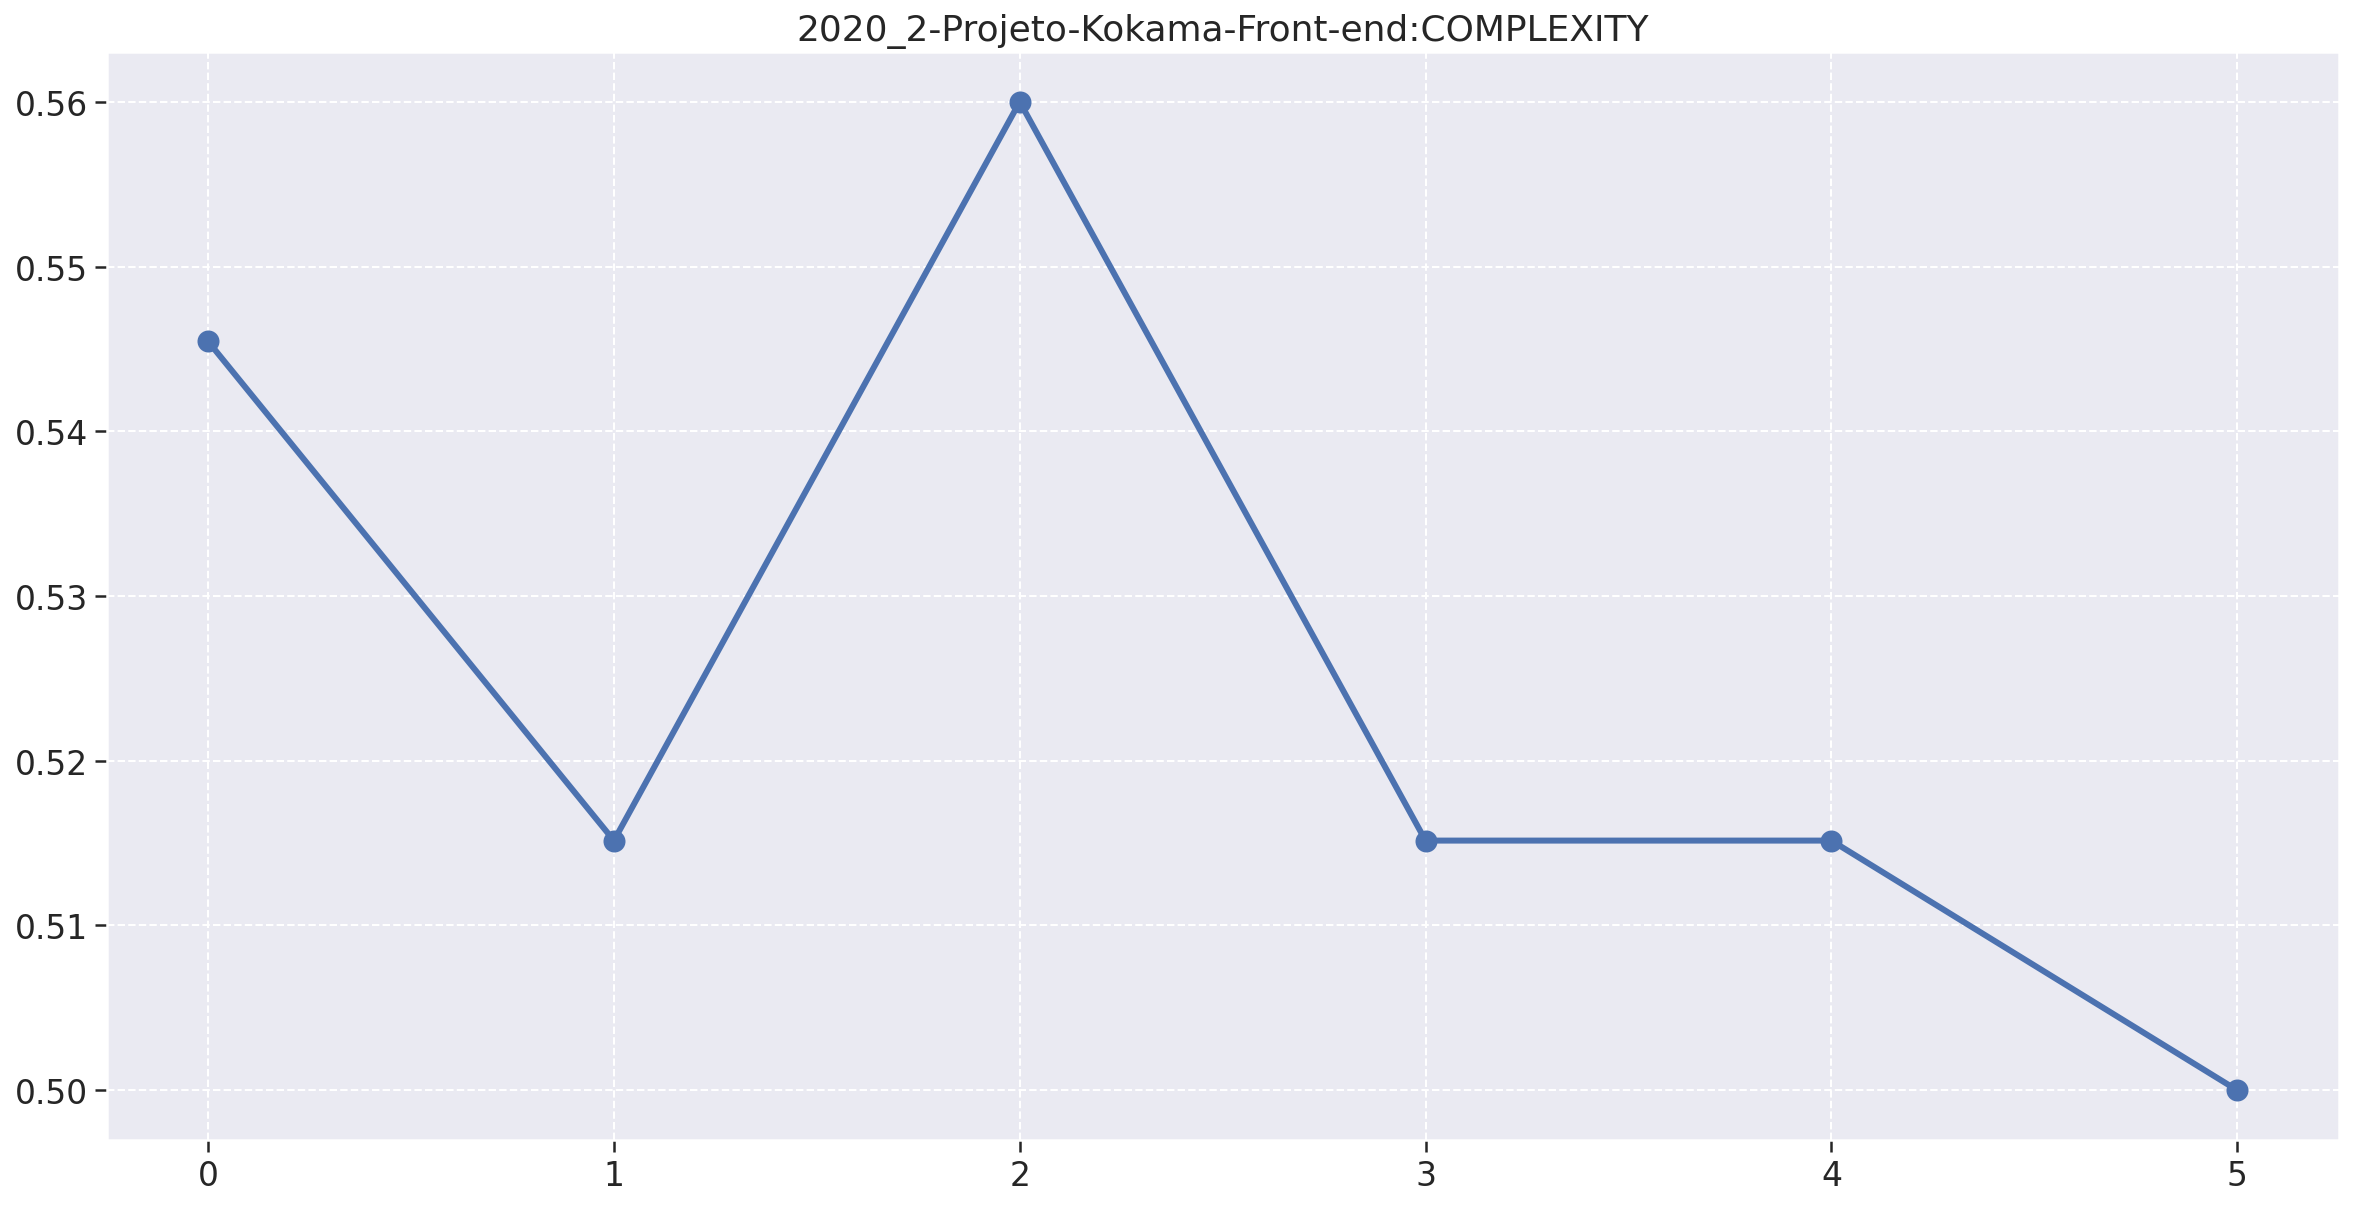

In [34]:
for repository, metrics_df in repository_metrics.items(): 
    fig = plt.figure(figsize=(20, 10))
    plt.title(f"{repository}:COMPLEXITY")
    plt.plot(metrics_df['m1'], linewidth=3, marker='o', markersize=10)

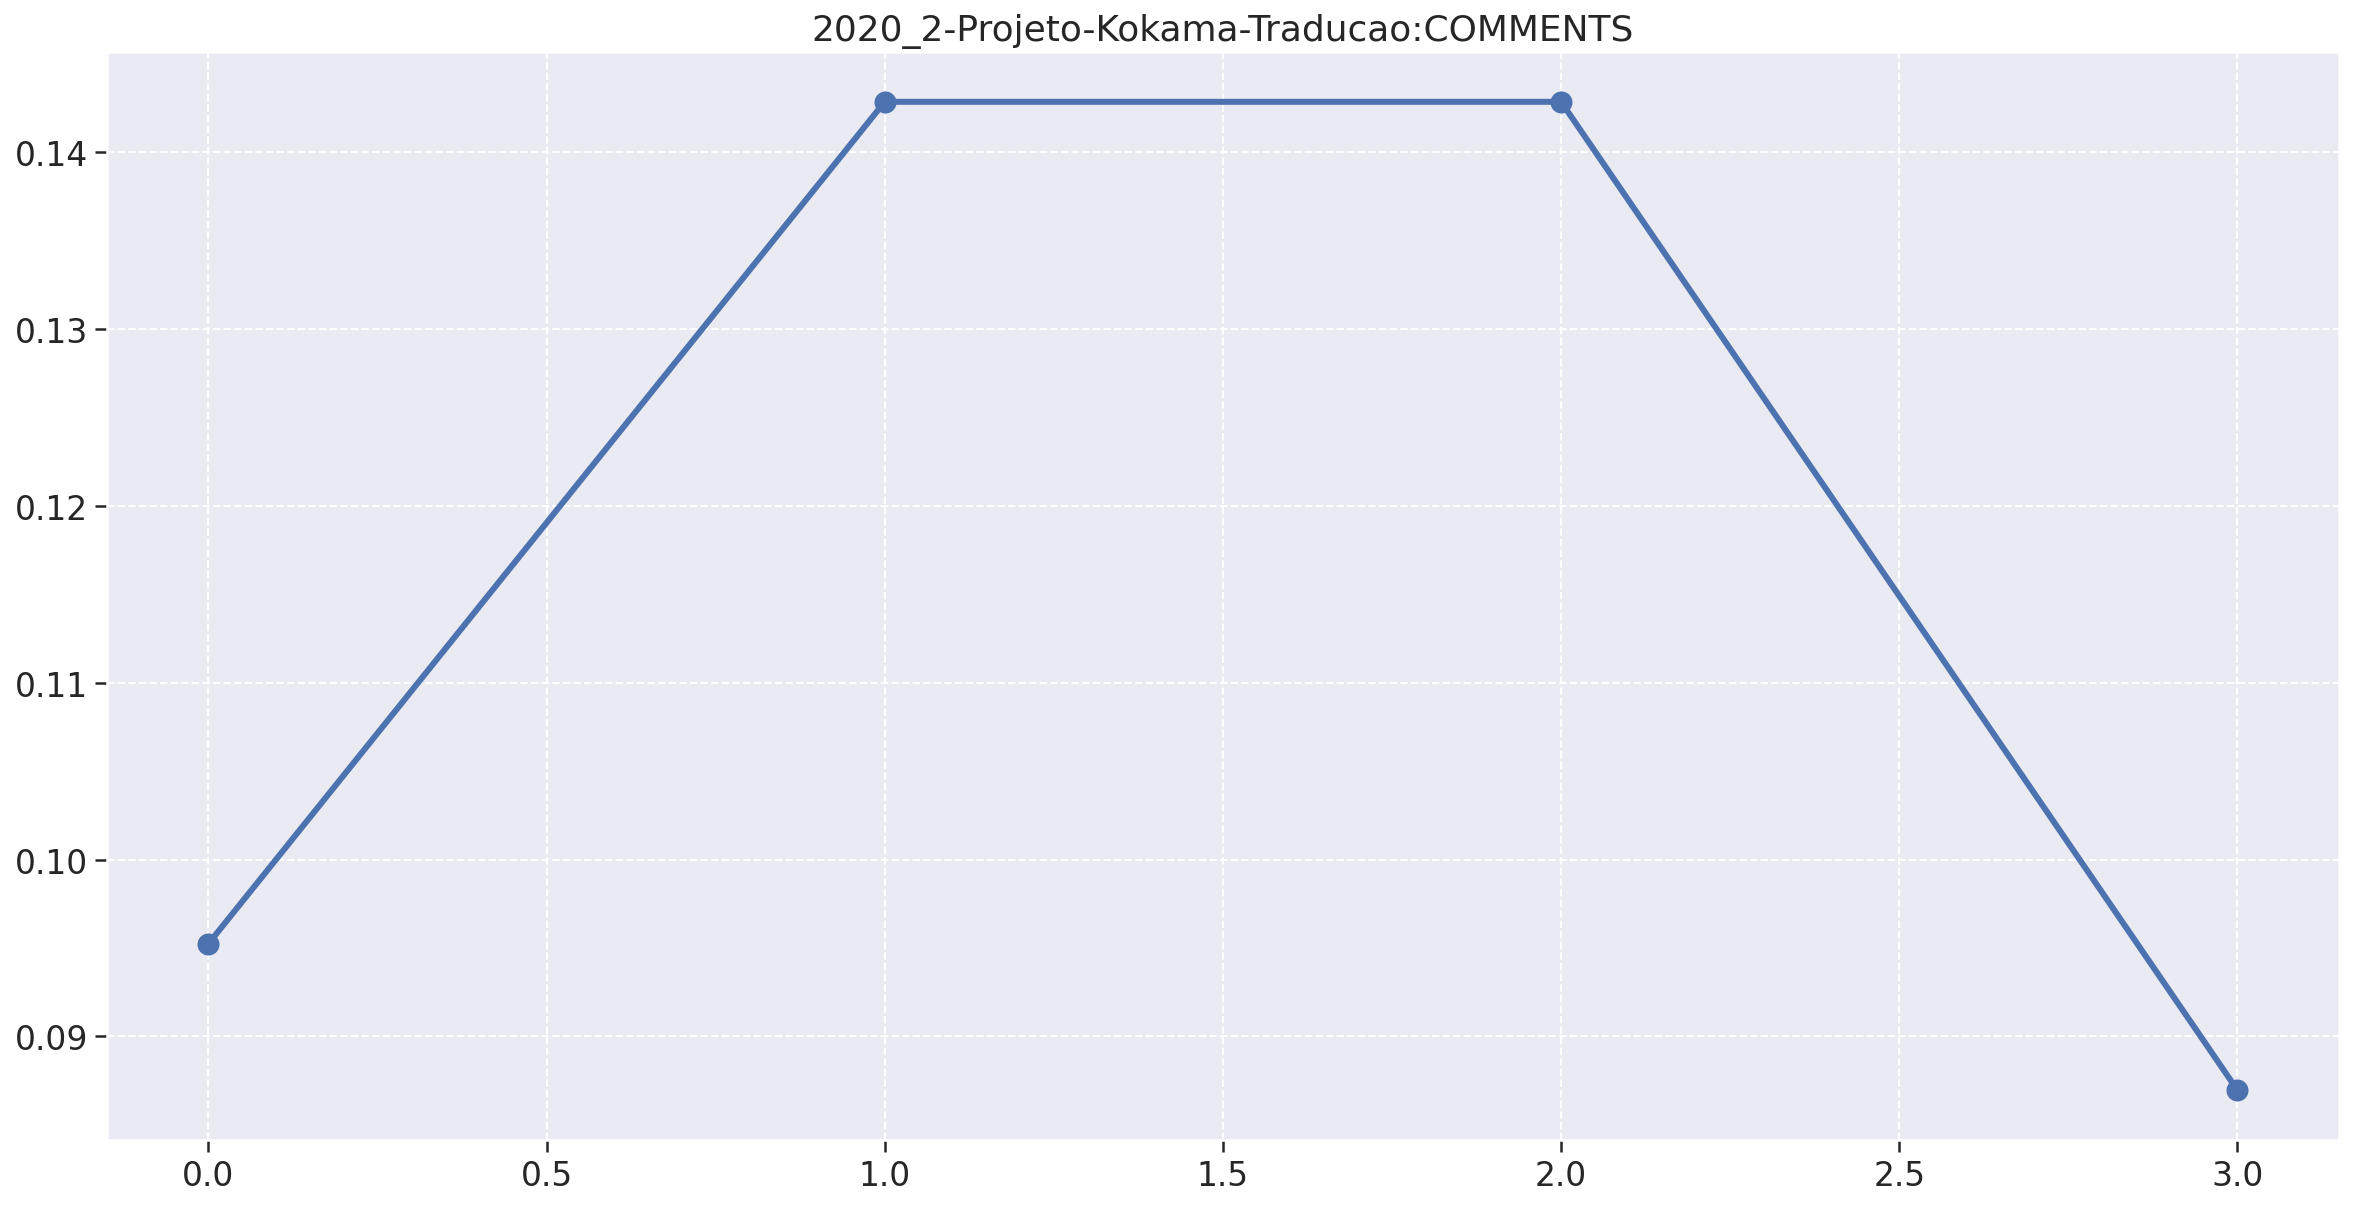

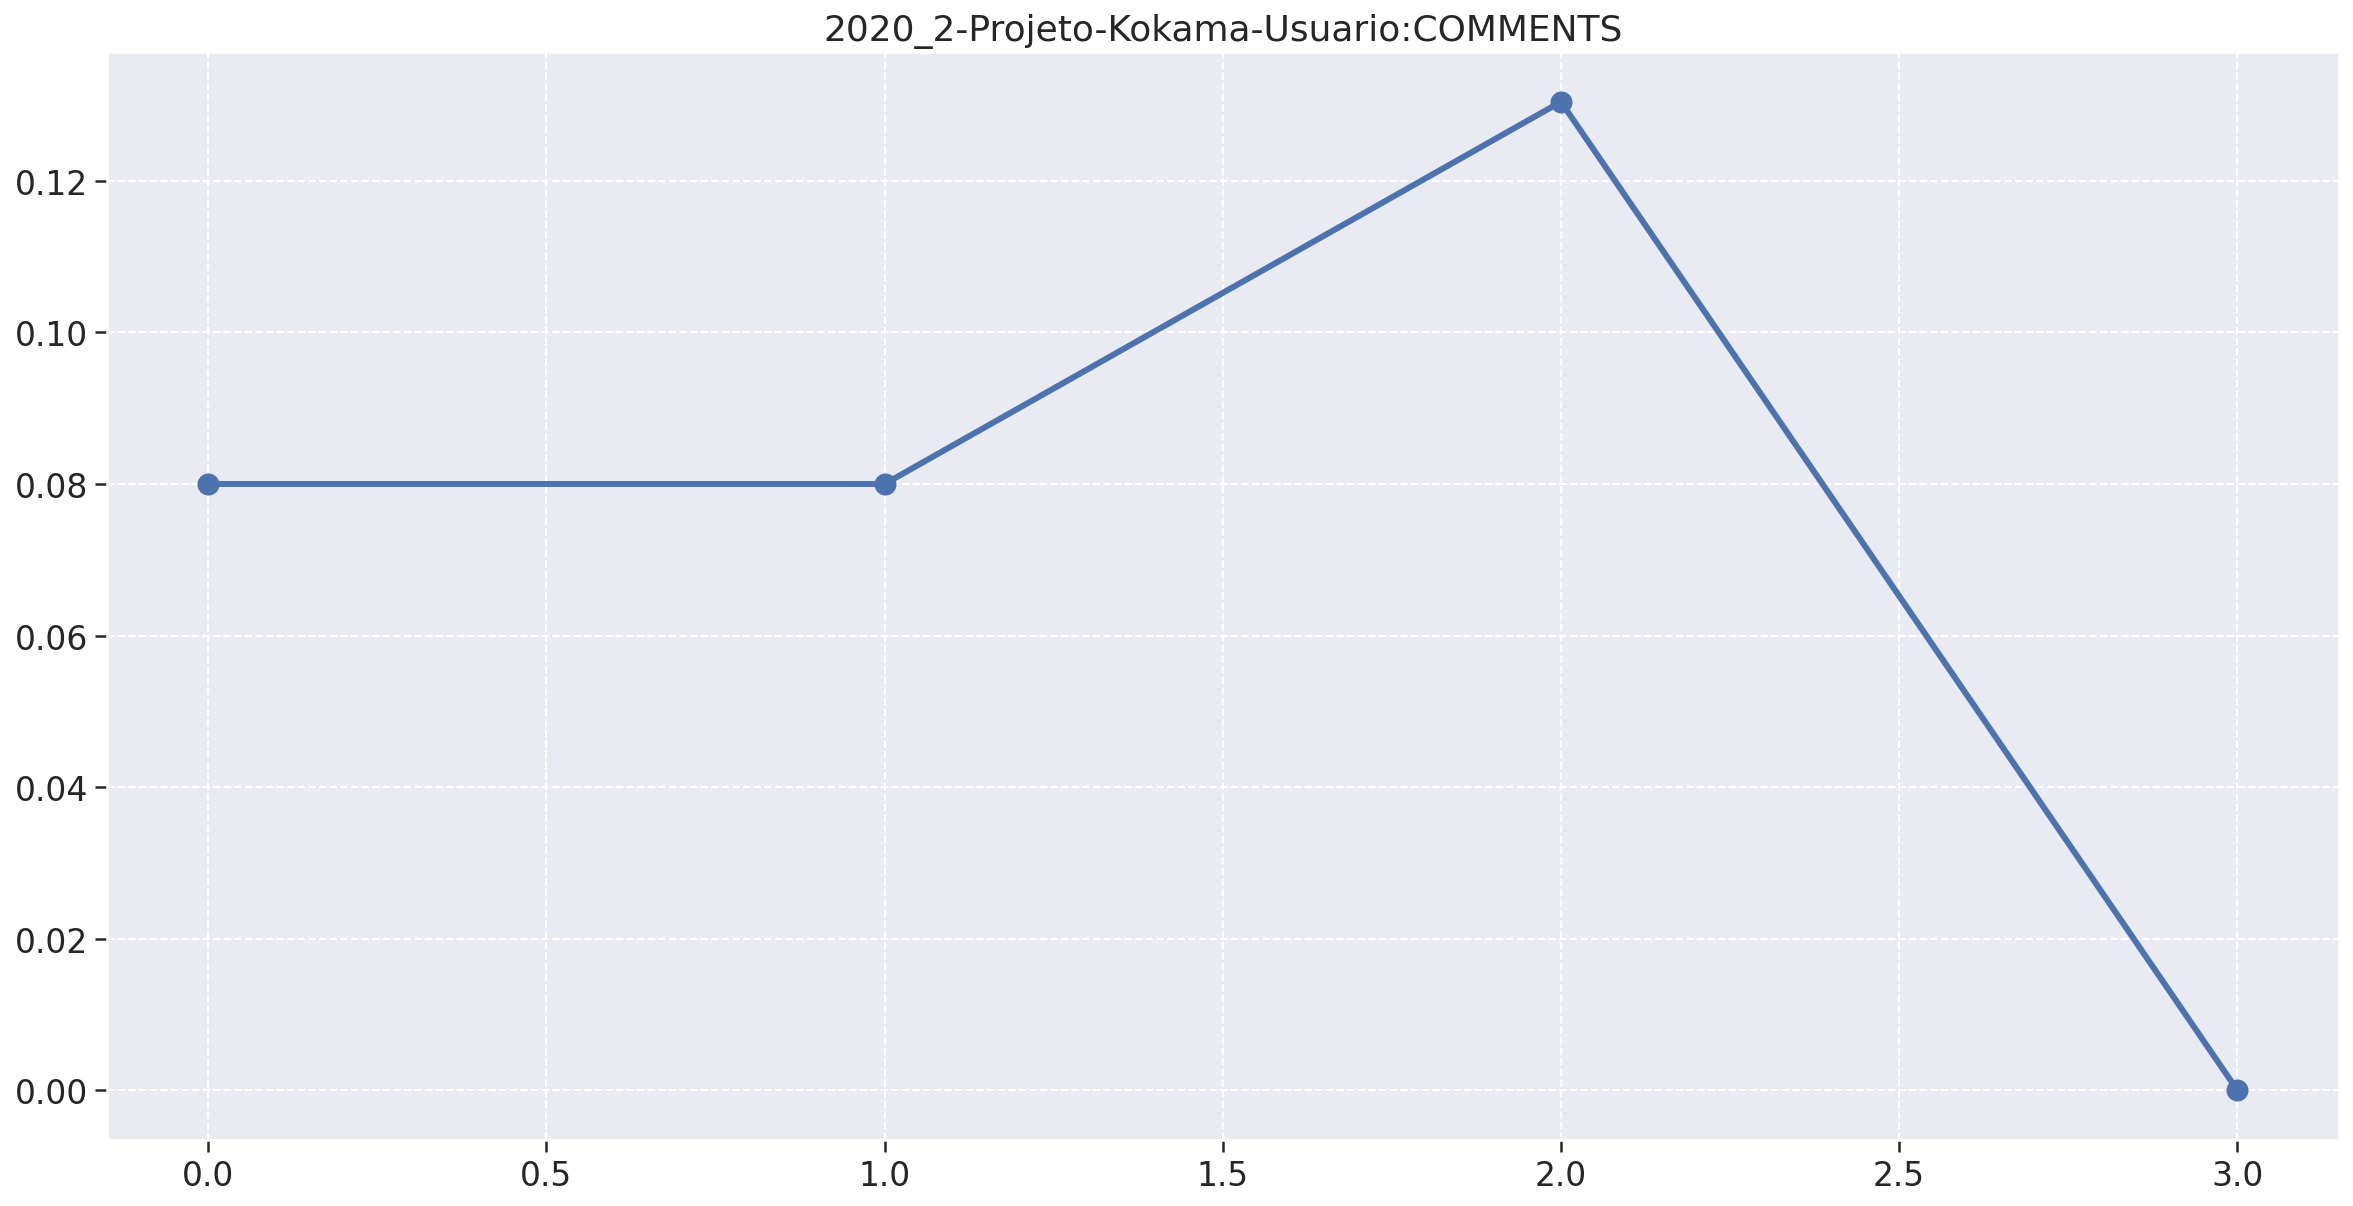

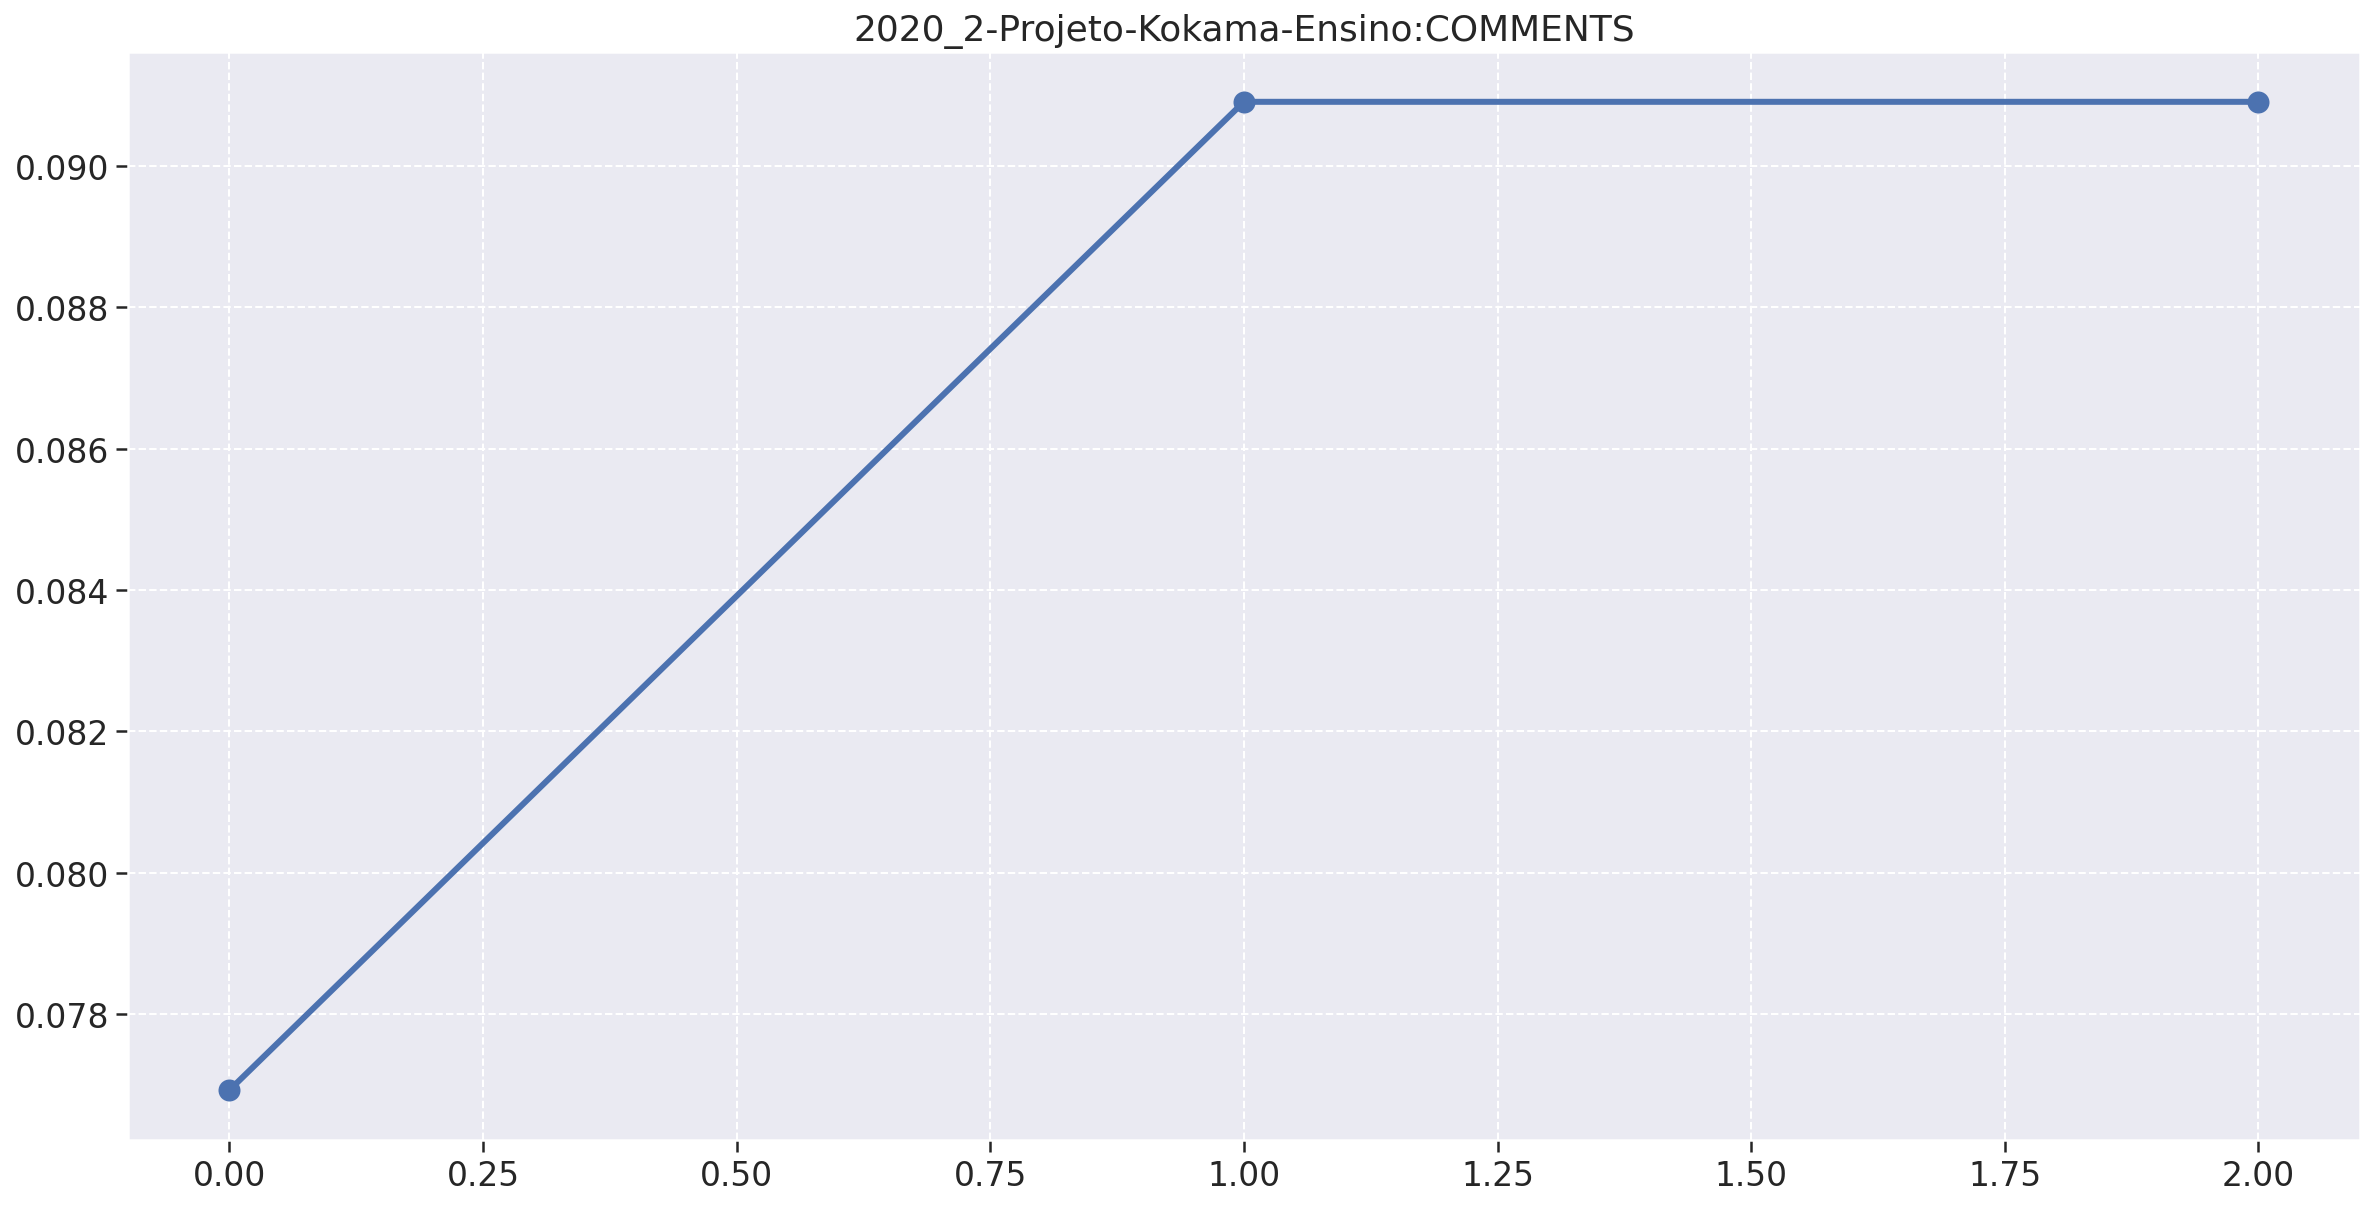

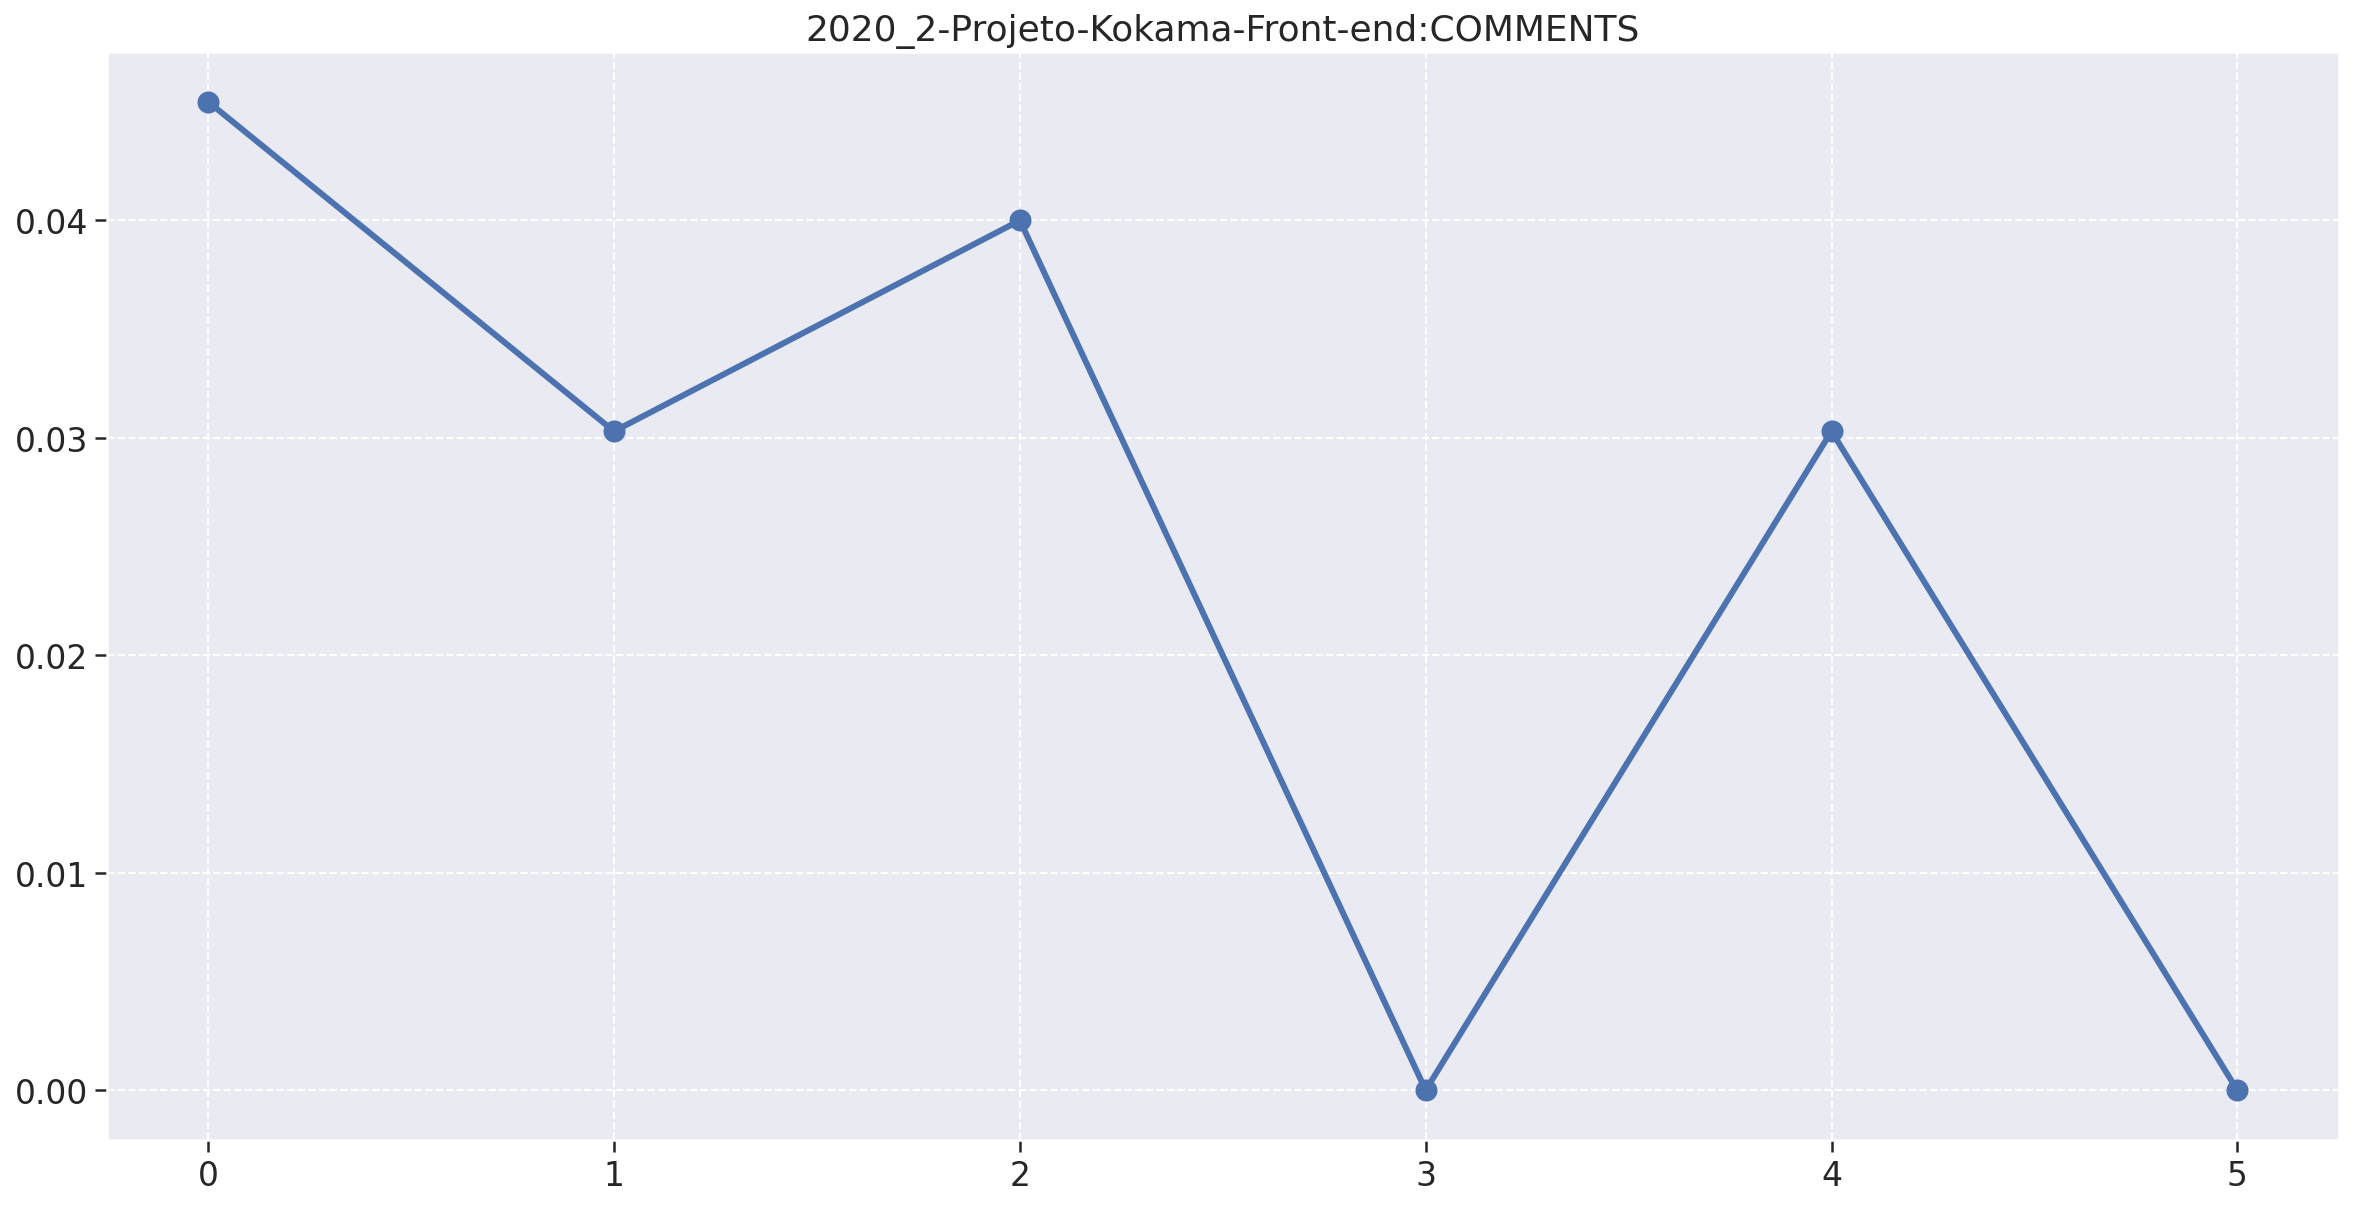

In [35]:
for repository, metrics_df in repository_metrics.items(): 
    fig = plt.figure(figsize=(20, 10))
    plt.title(f"{repository}:COMMENTS")
    plt.plot(metrics_df['m2'], linewidth=3, marker='o', markersize=10)

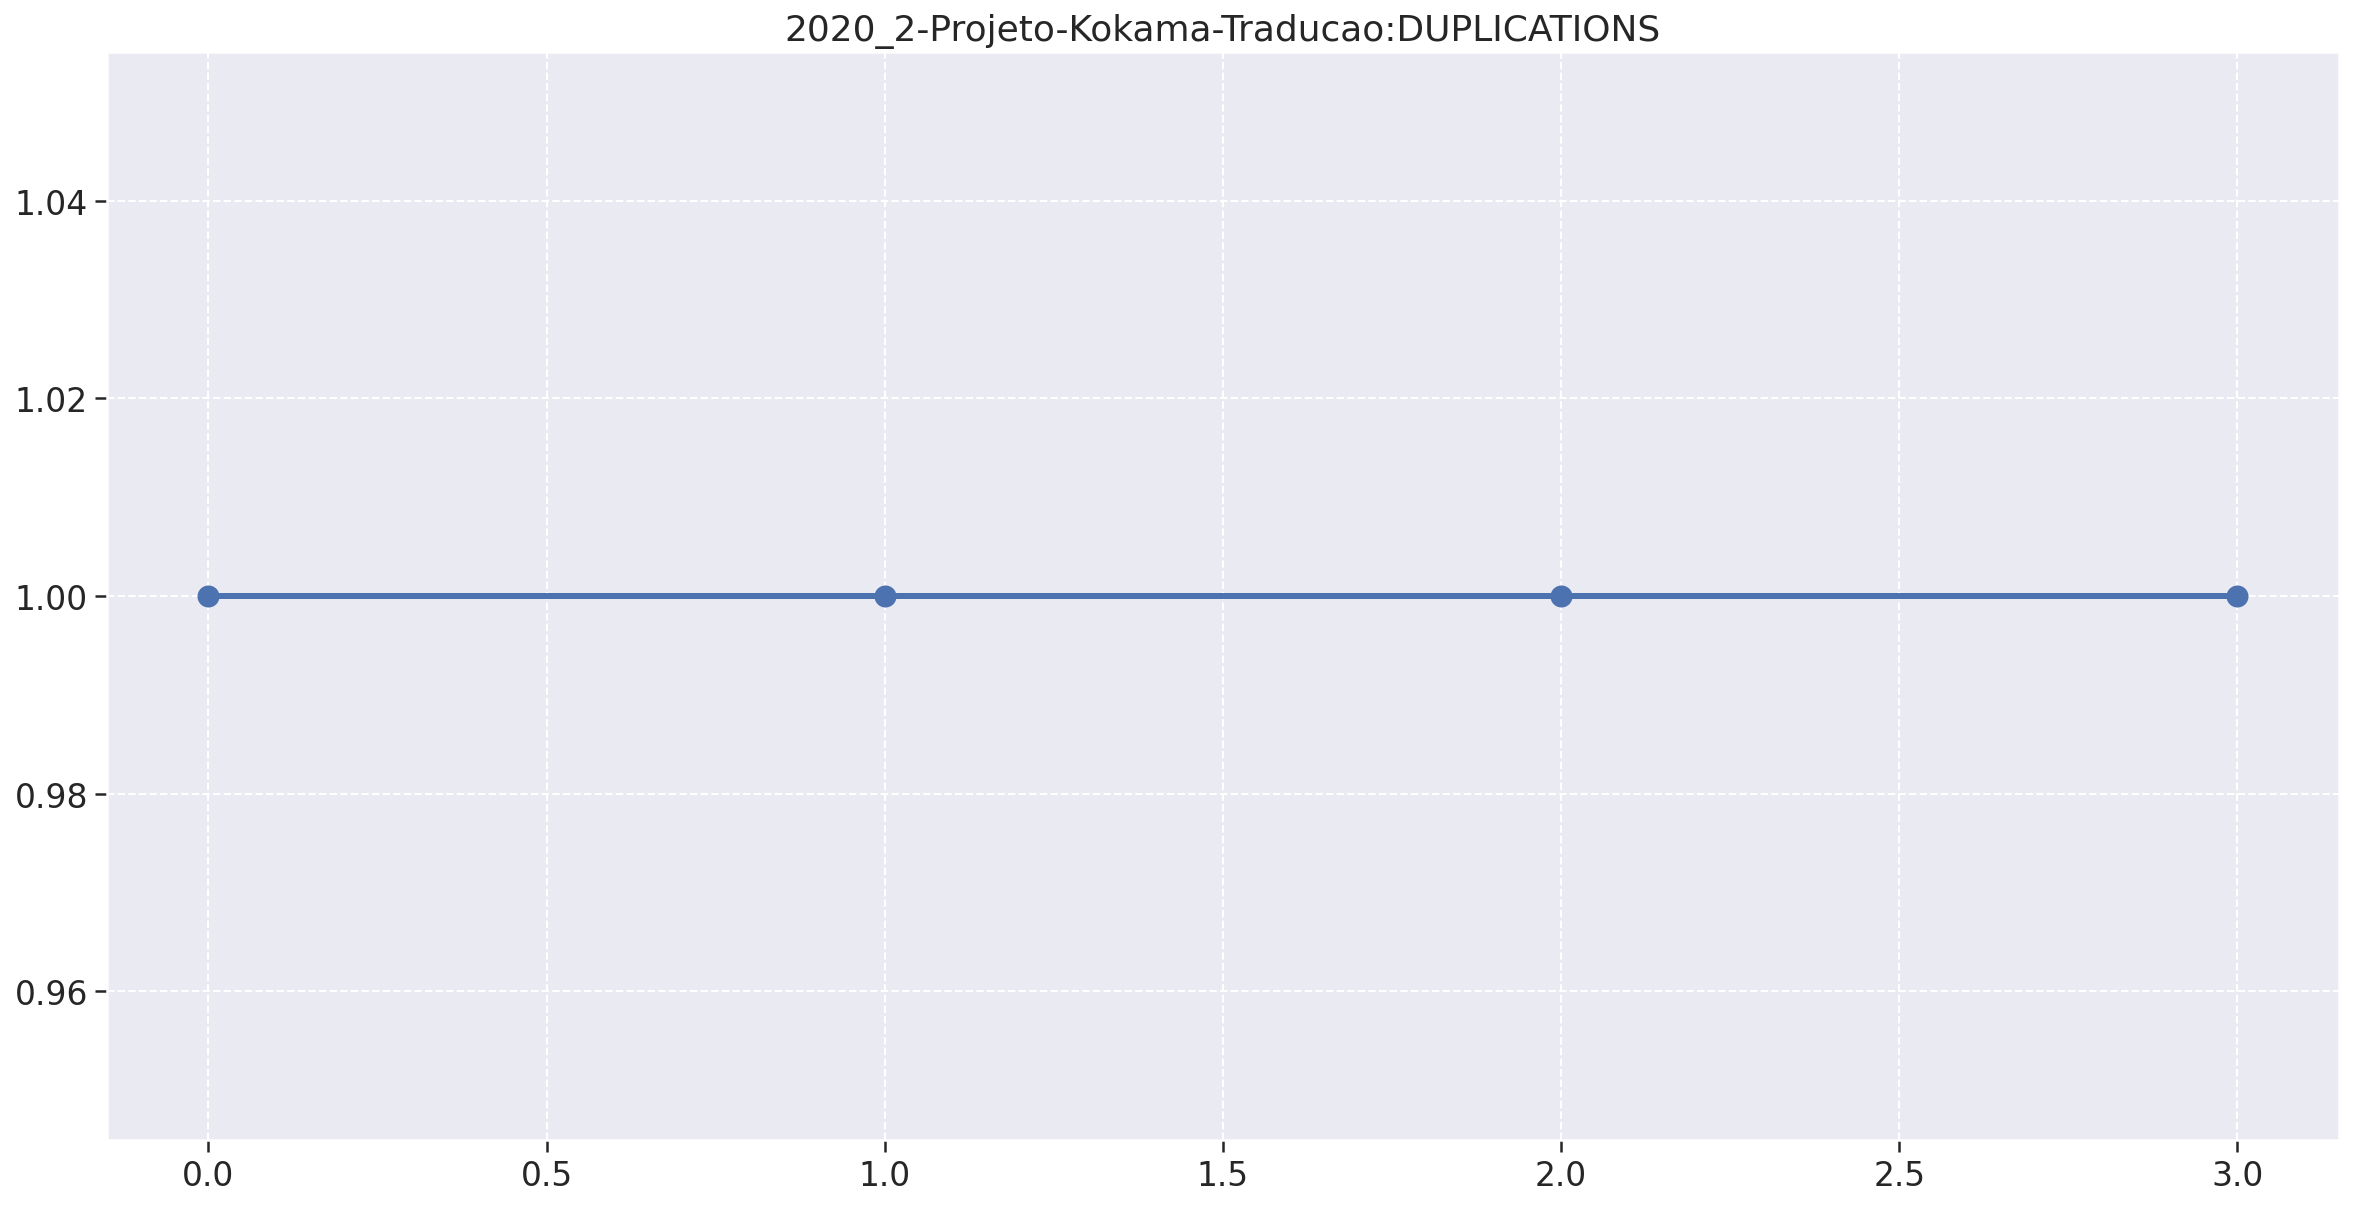

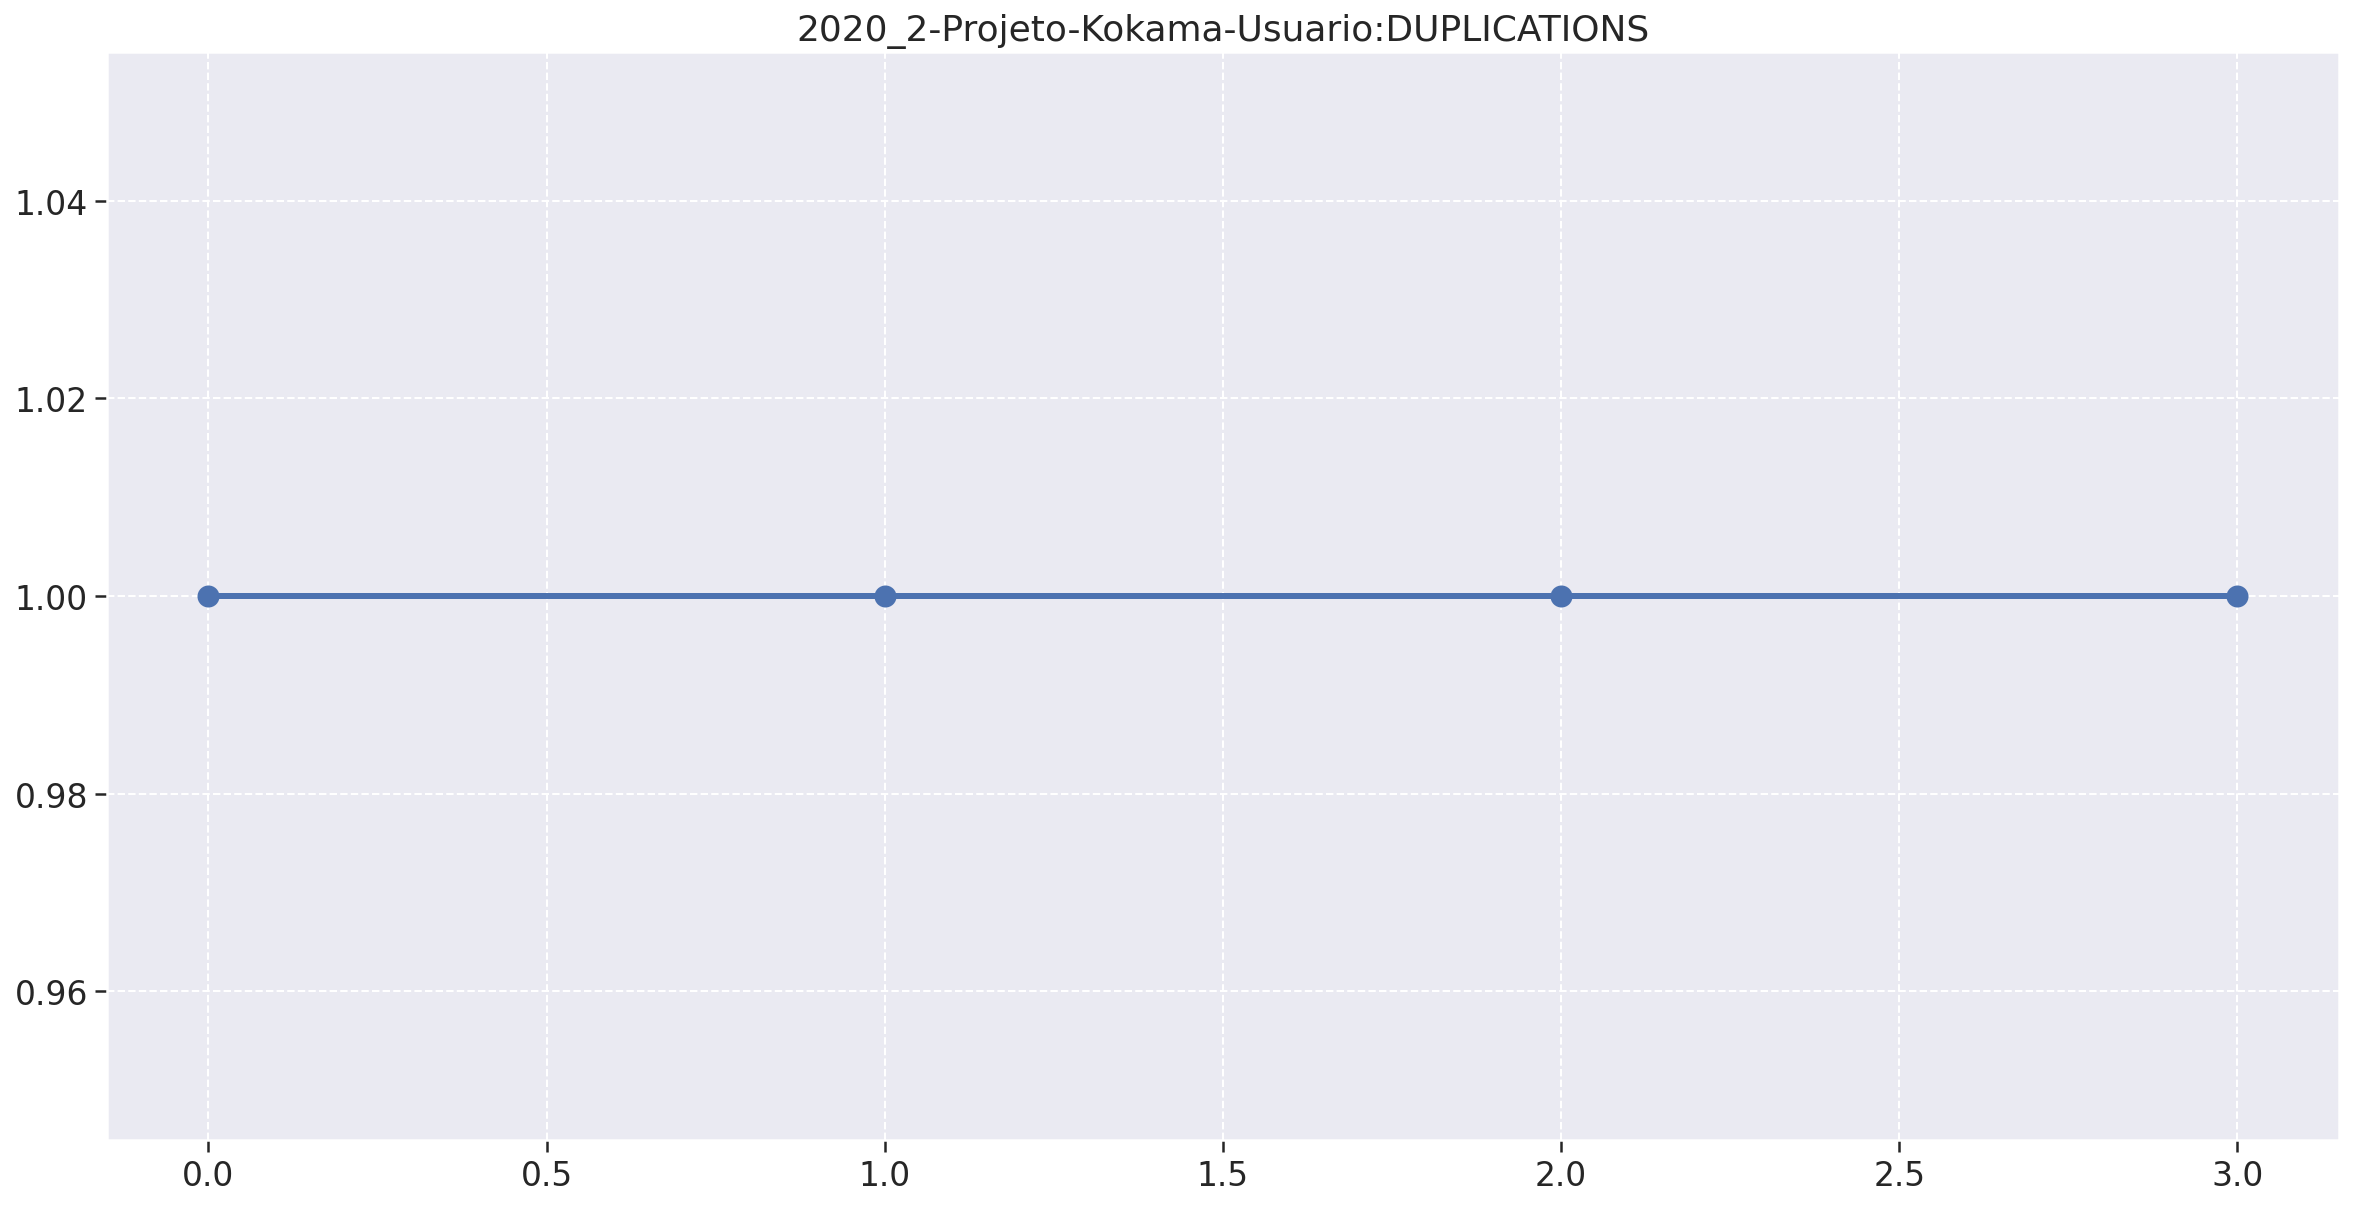

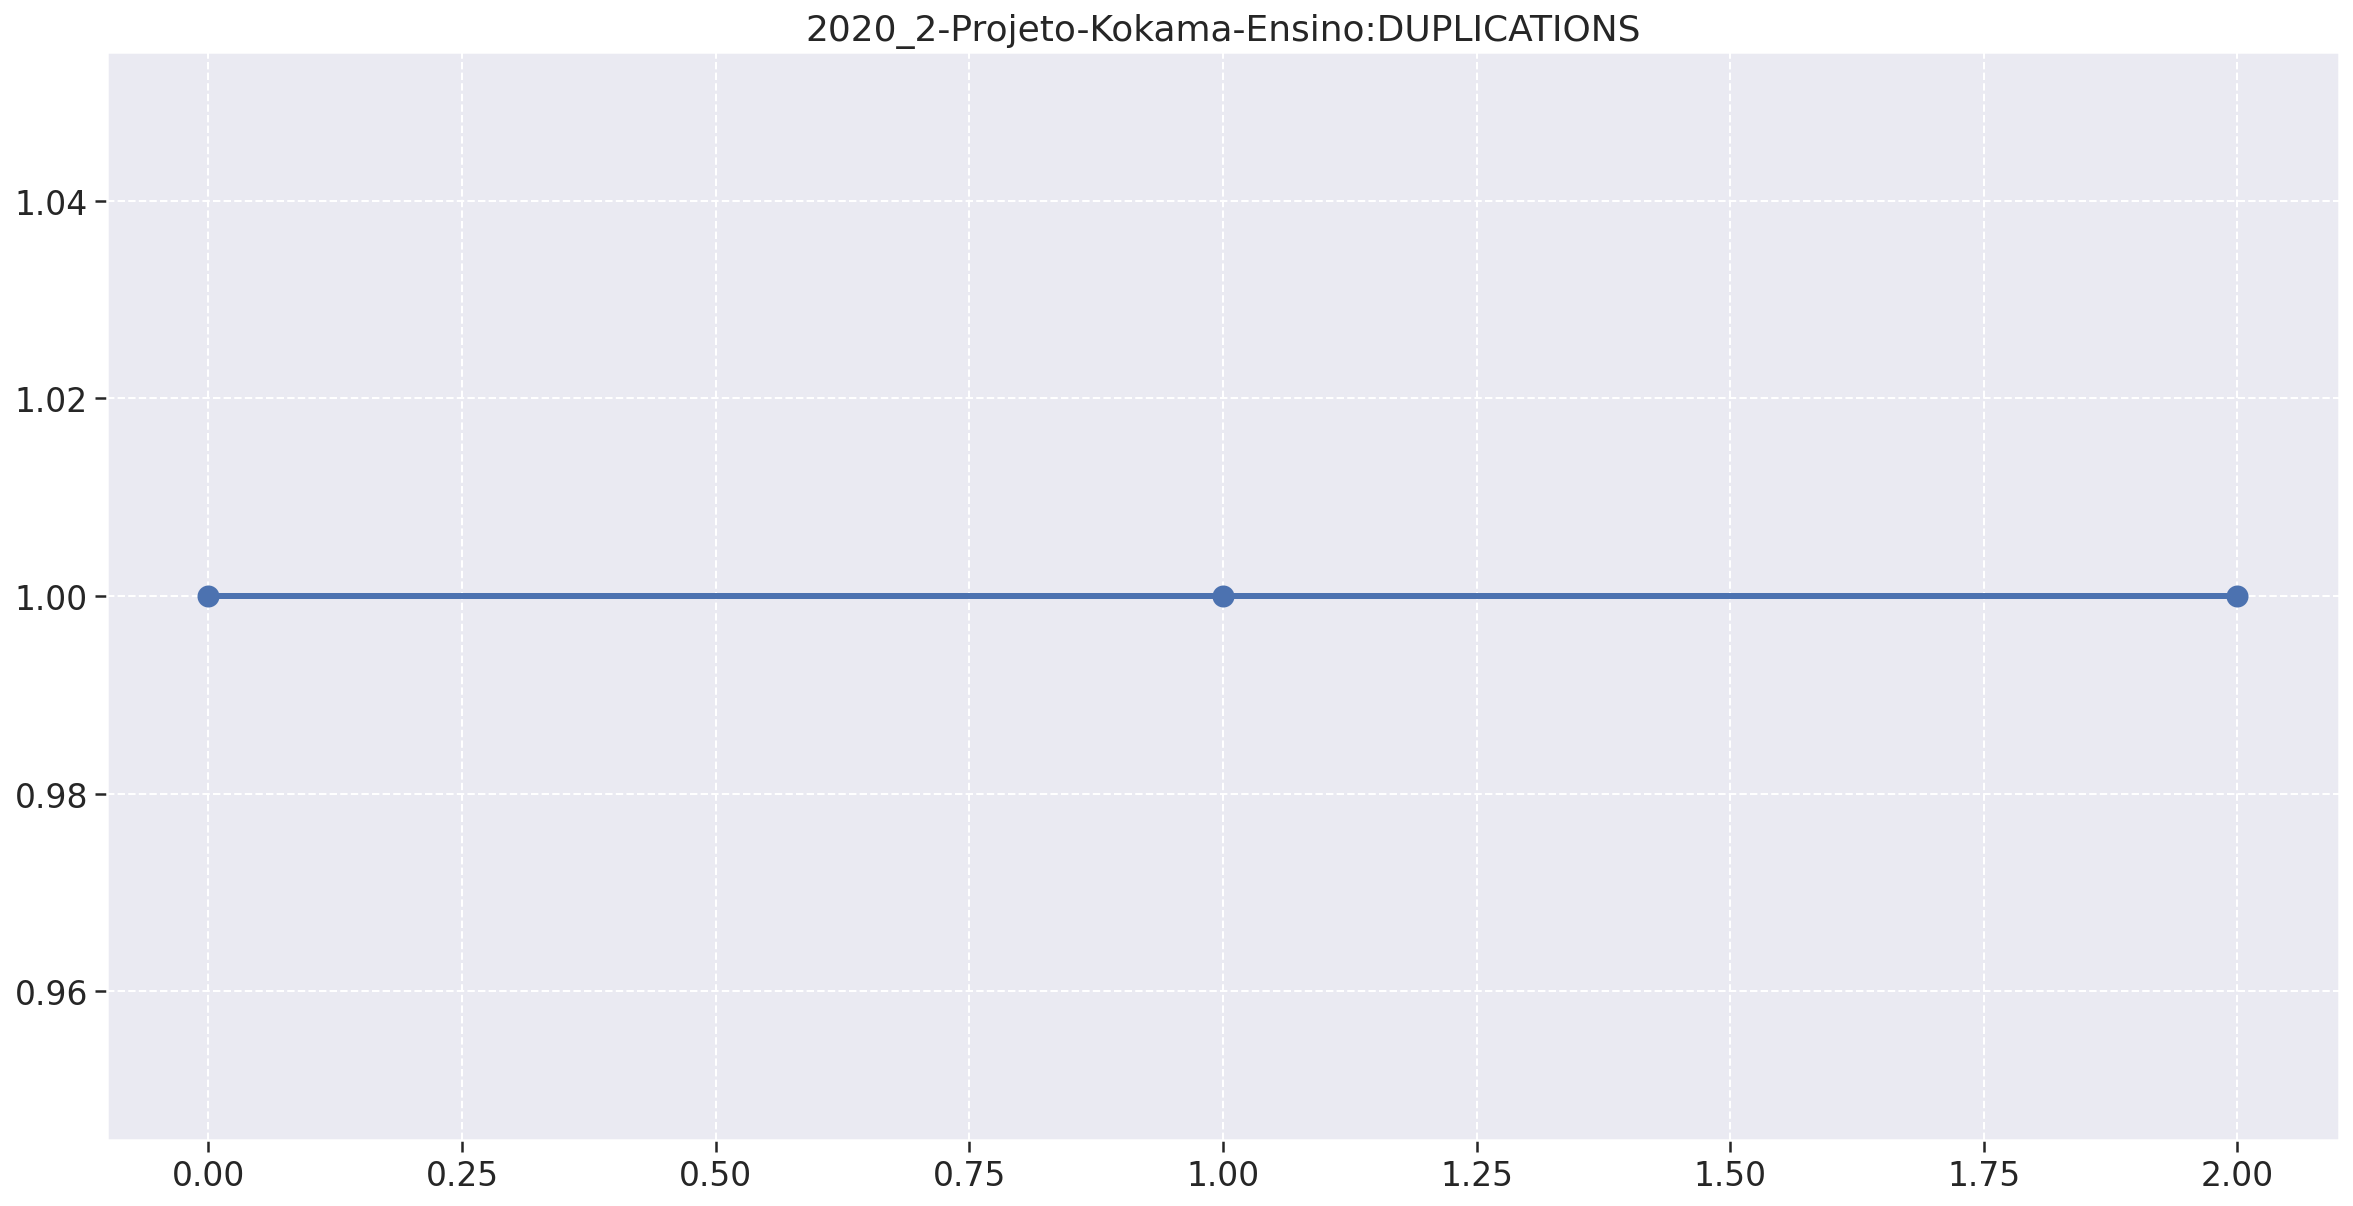

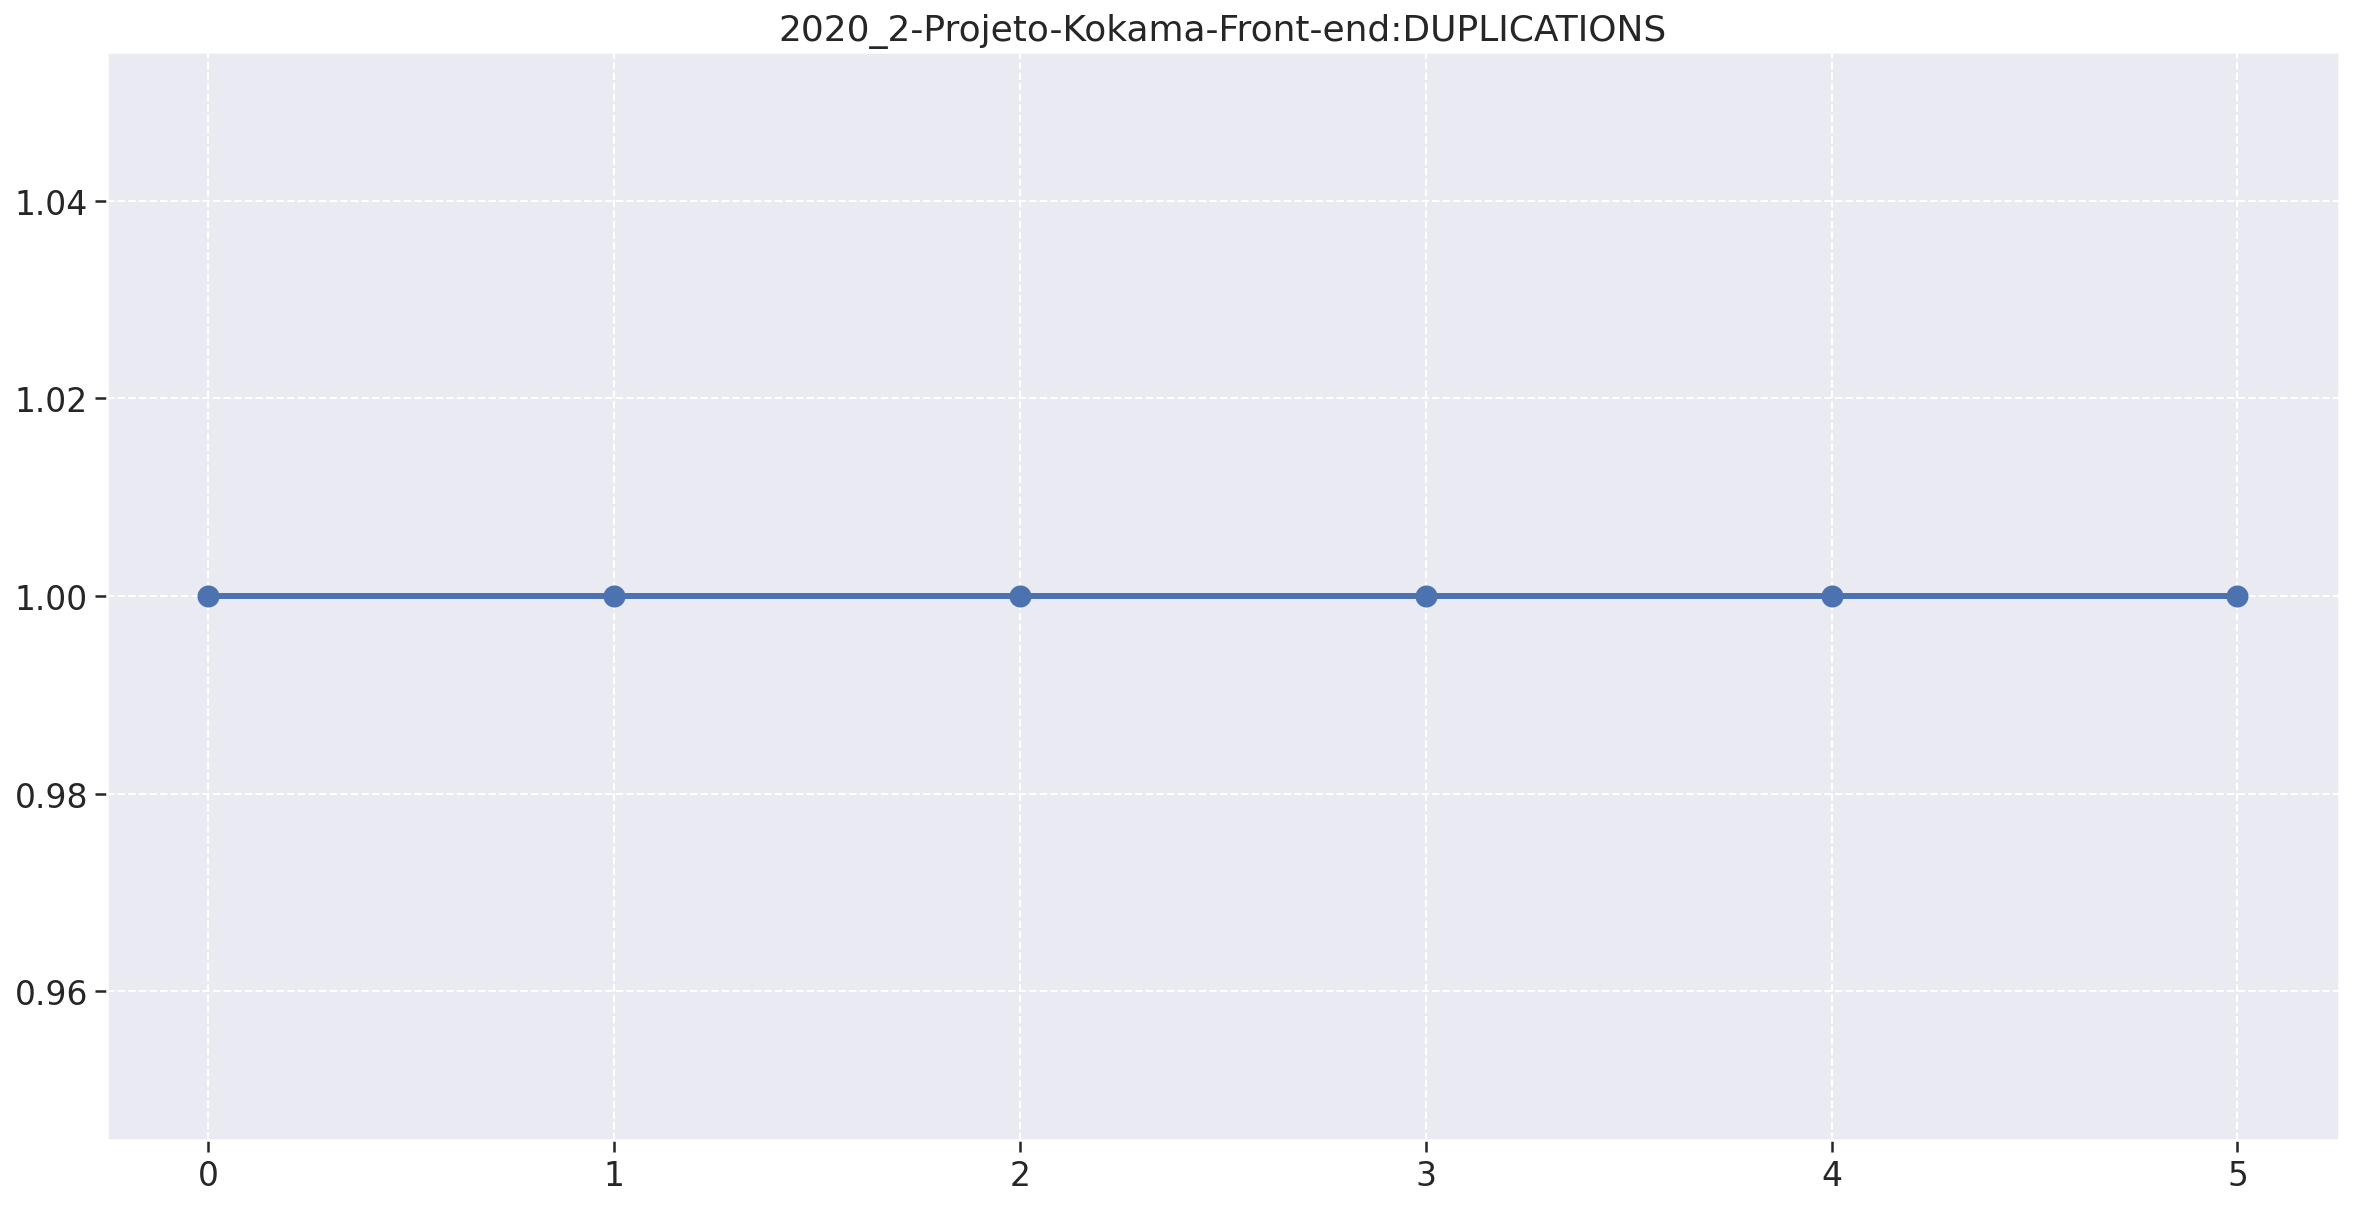

In [36]:
for repository, metrics_df in repository_metrics.items(): 
    fig = plt.figure(figsize=(20, 10))
    plt.title(f"{repository}:DUPLICATIONS")
    plt.plot(metrics_df['m3'], linewidth=3, marker='o', markersize=10)

### Sub characteristic aggregation


In [37]:
psc1 = 1
pm1 = 0.33
pm2 = 0.33
pm3 = 0.33

for repository, metrics_df in repository_metrics.items(): 
    metrics_df['asc1'] = ((metrics_df['m1']*pm1)+(metrics_df['m2']*pm2)+(metrics_df['m3']*pm3))*psc1


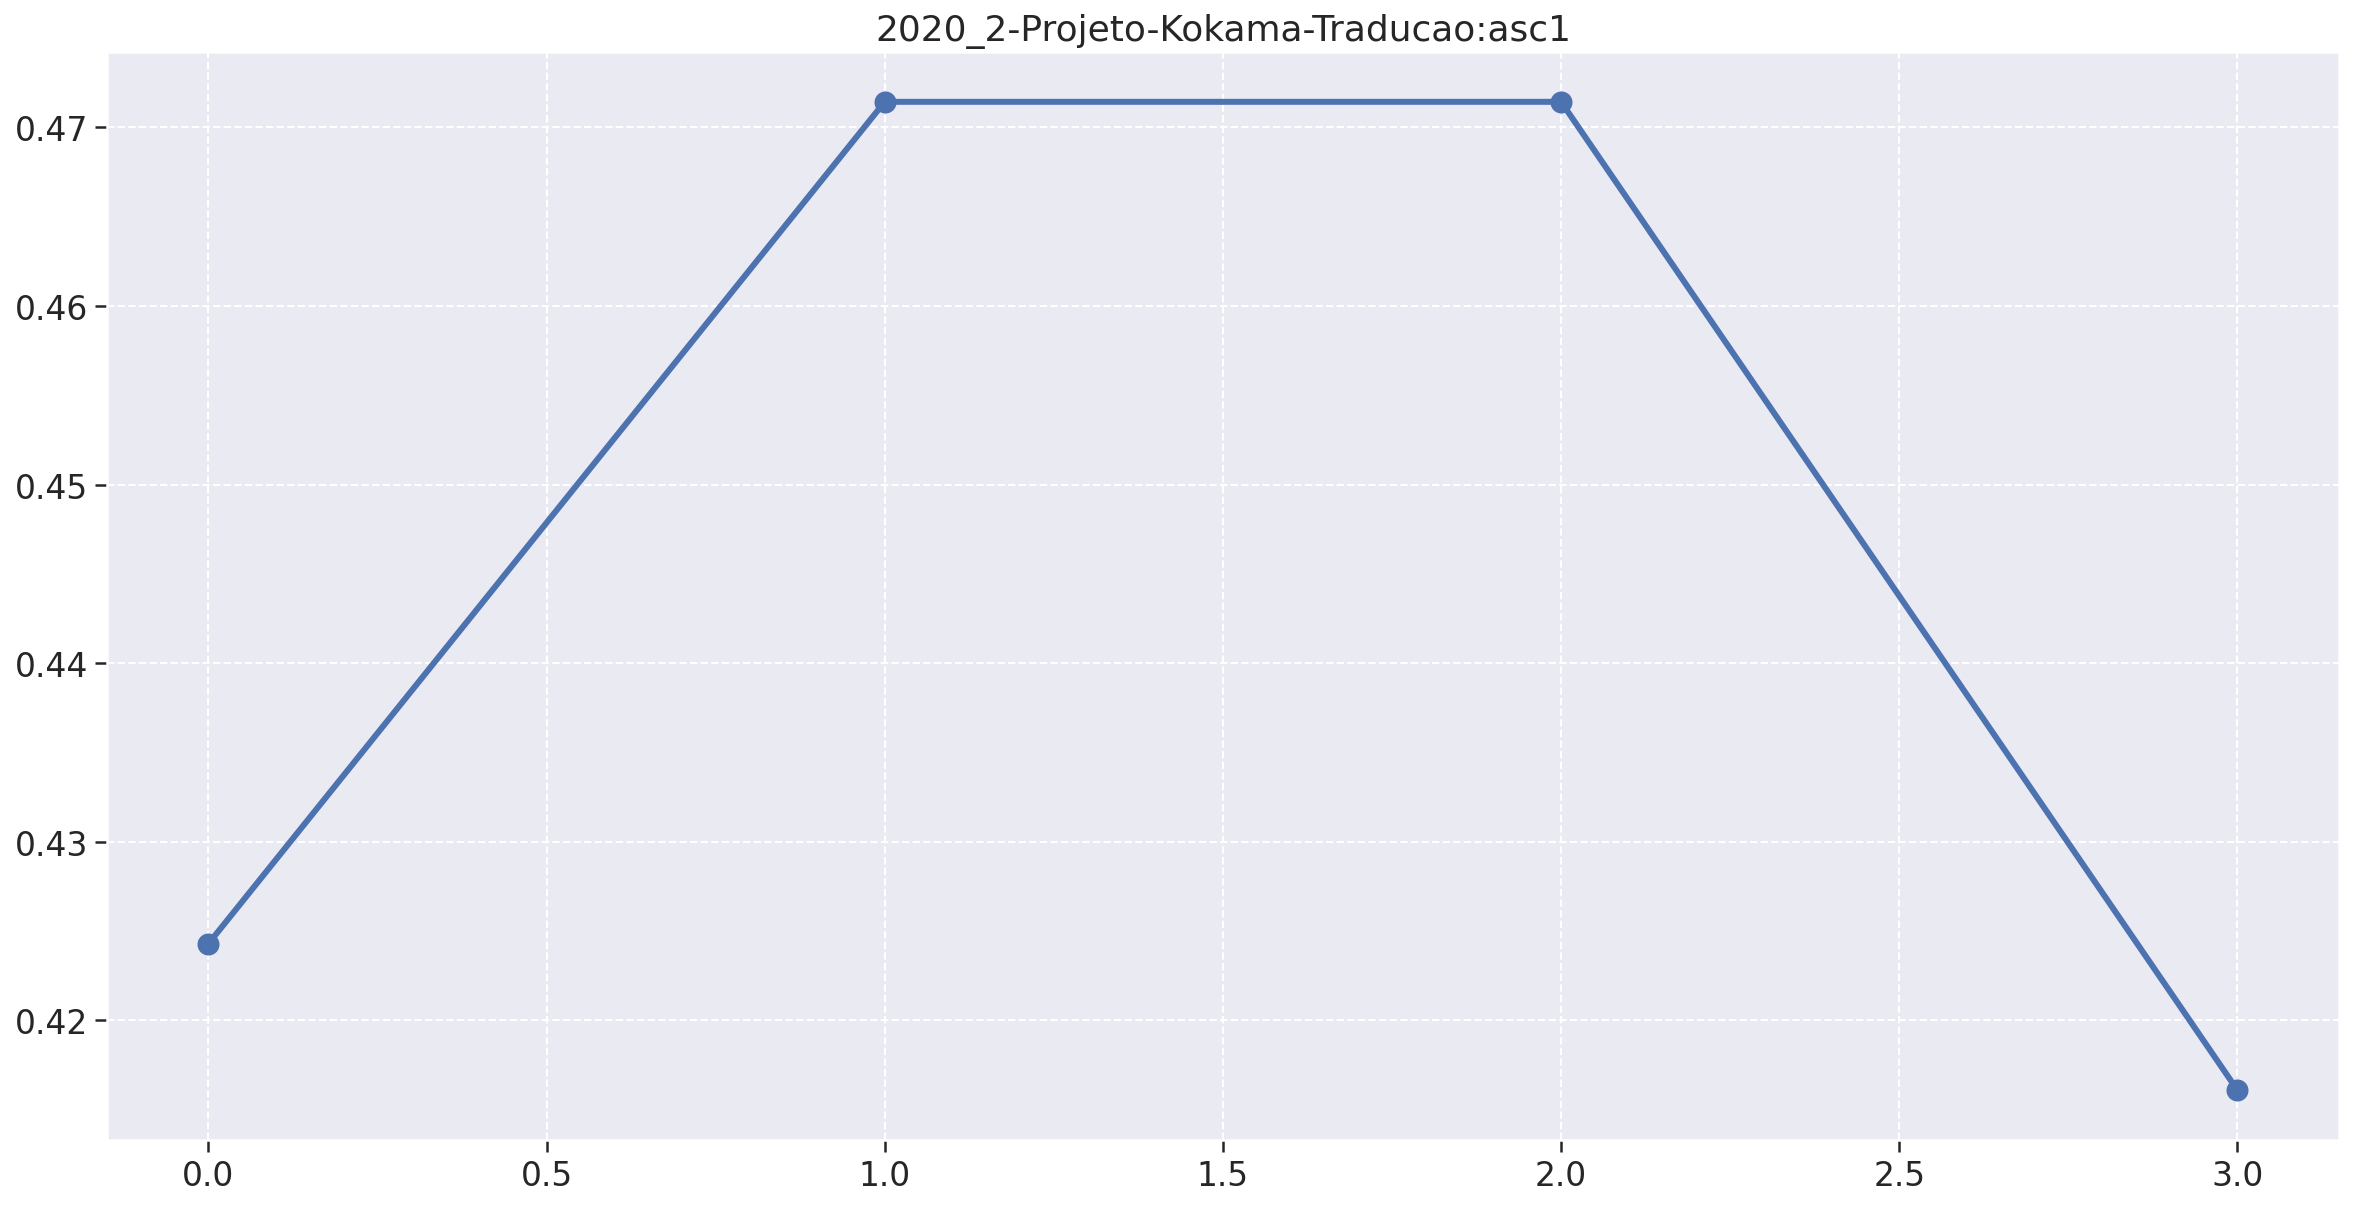

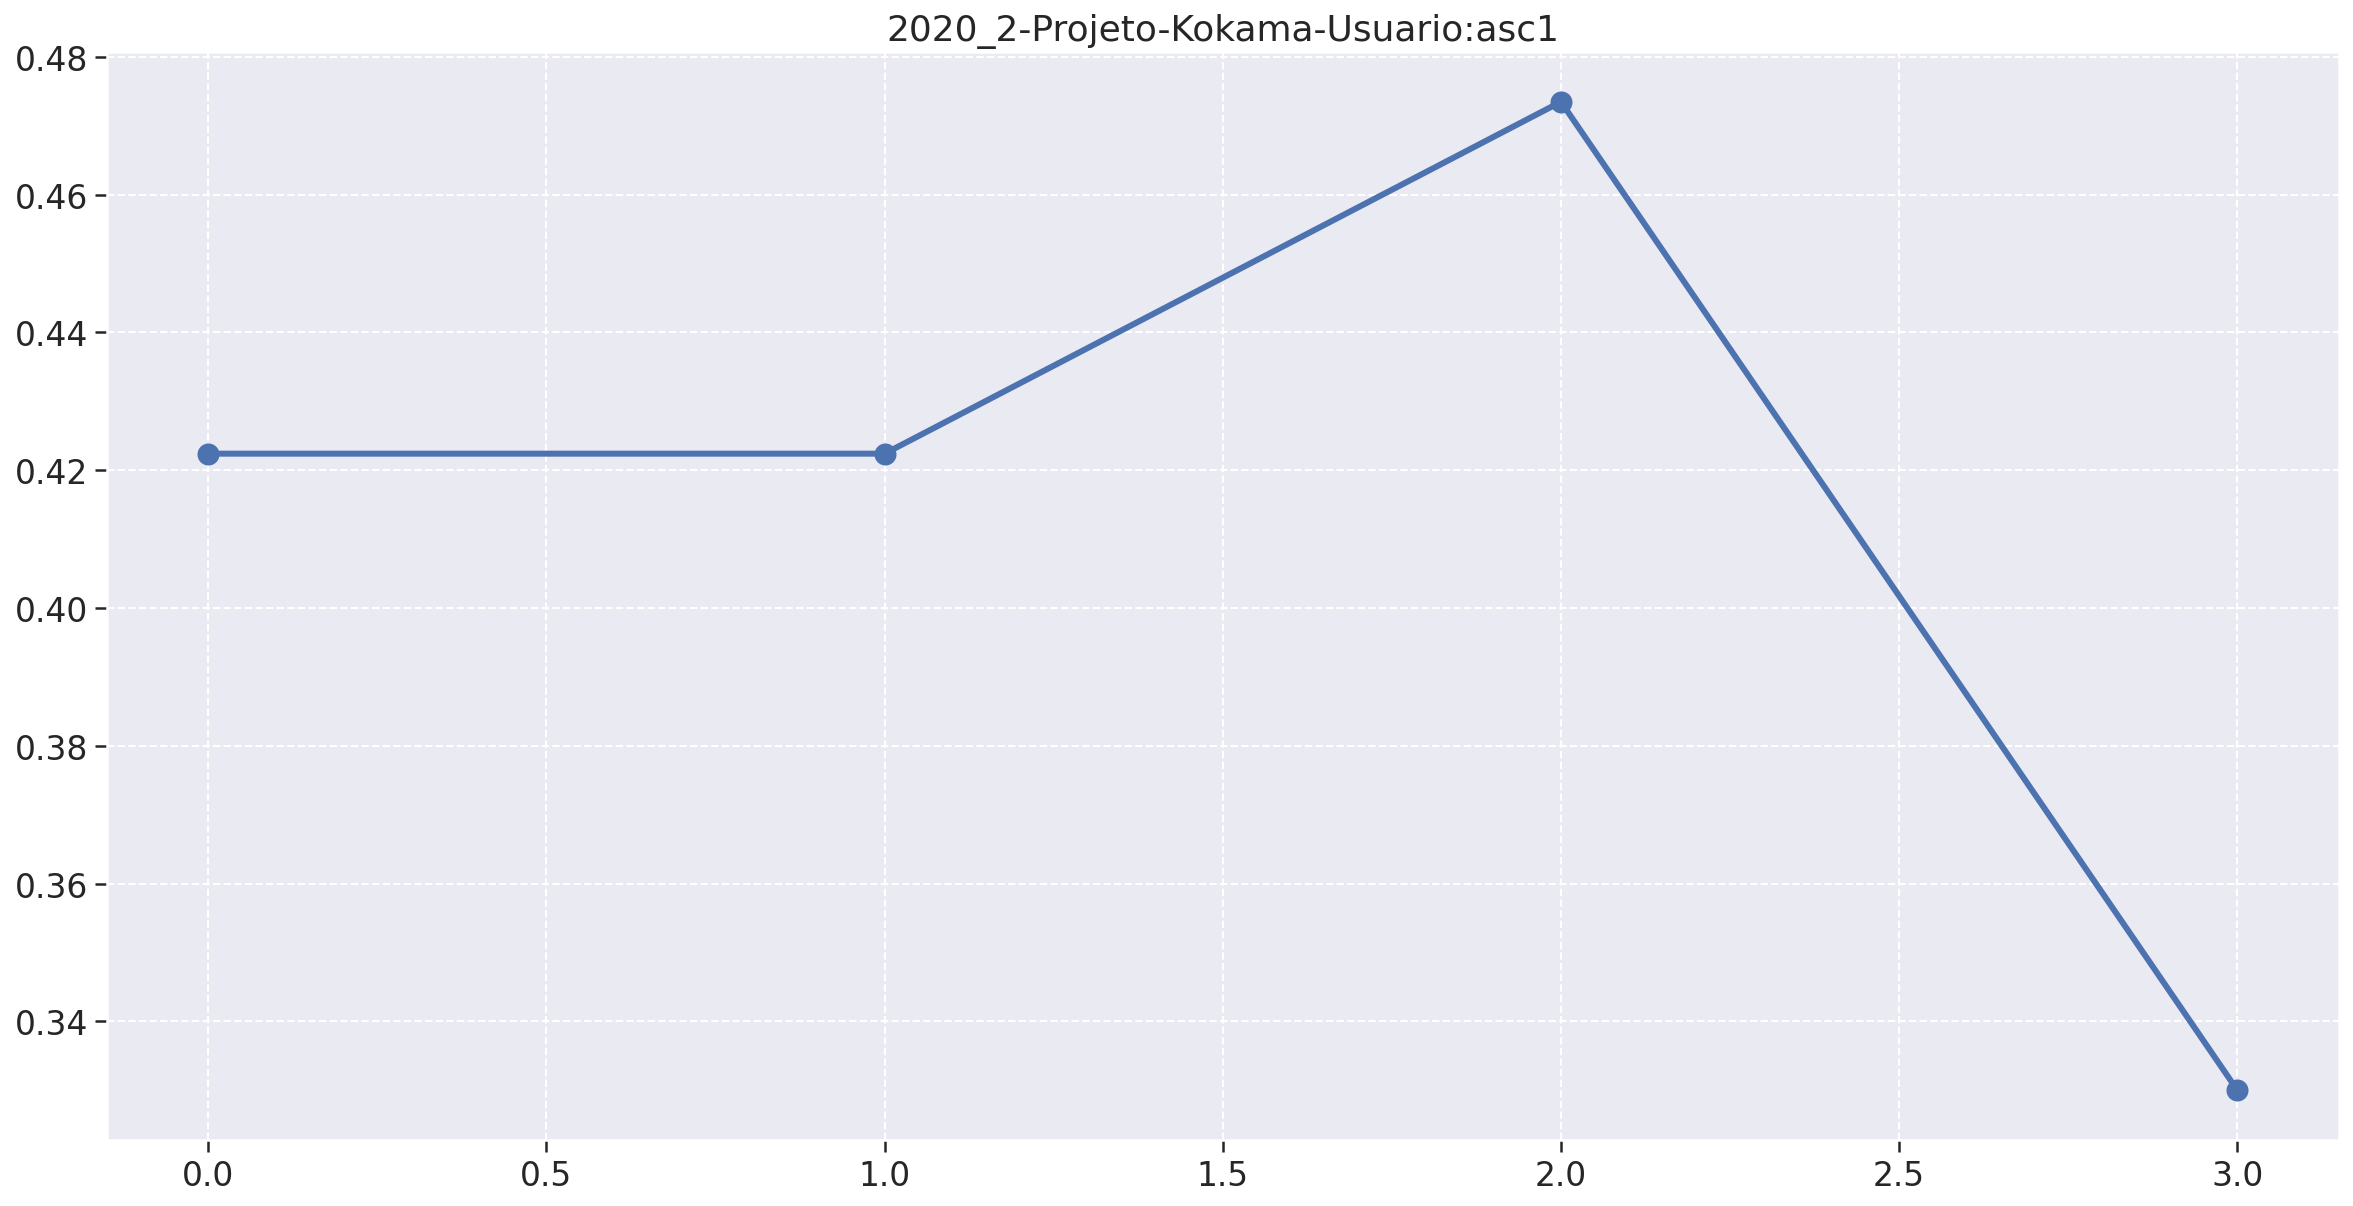

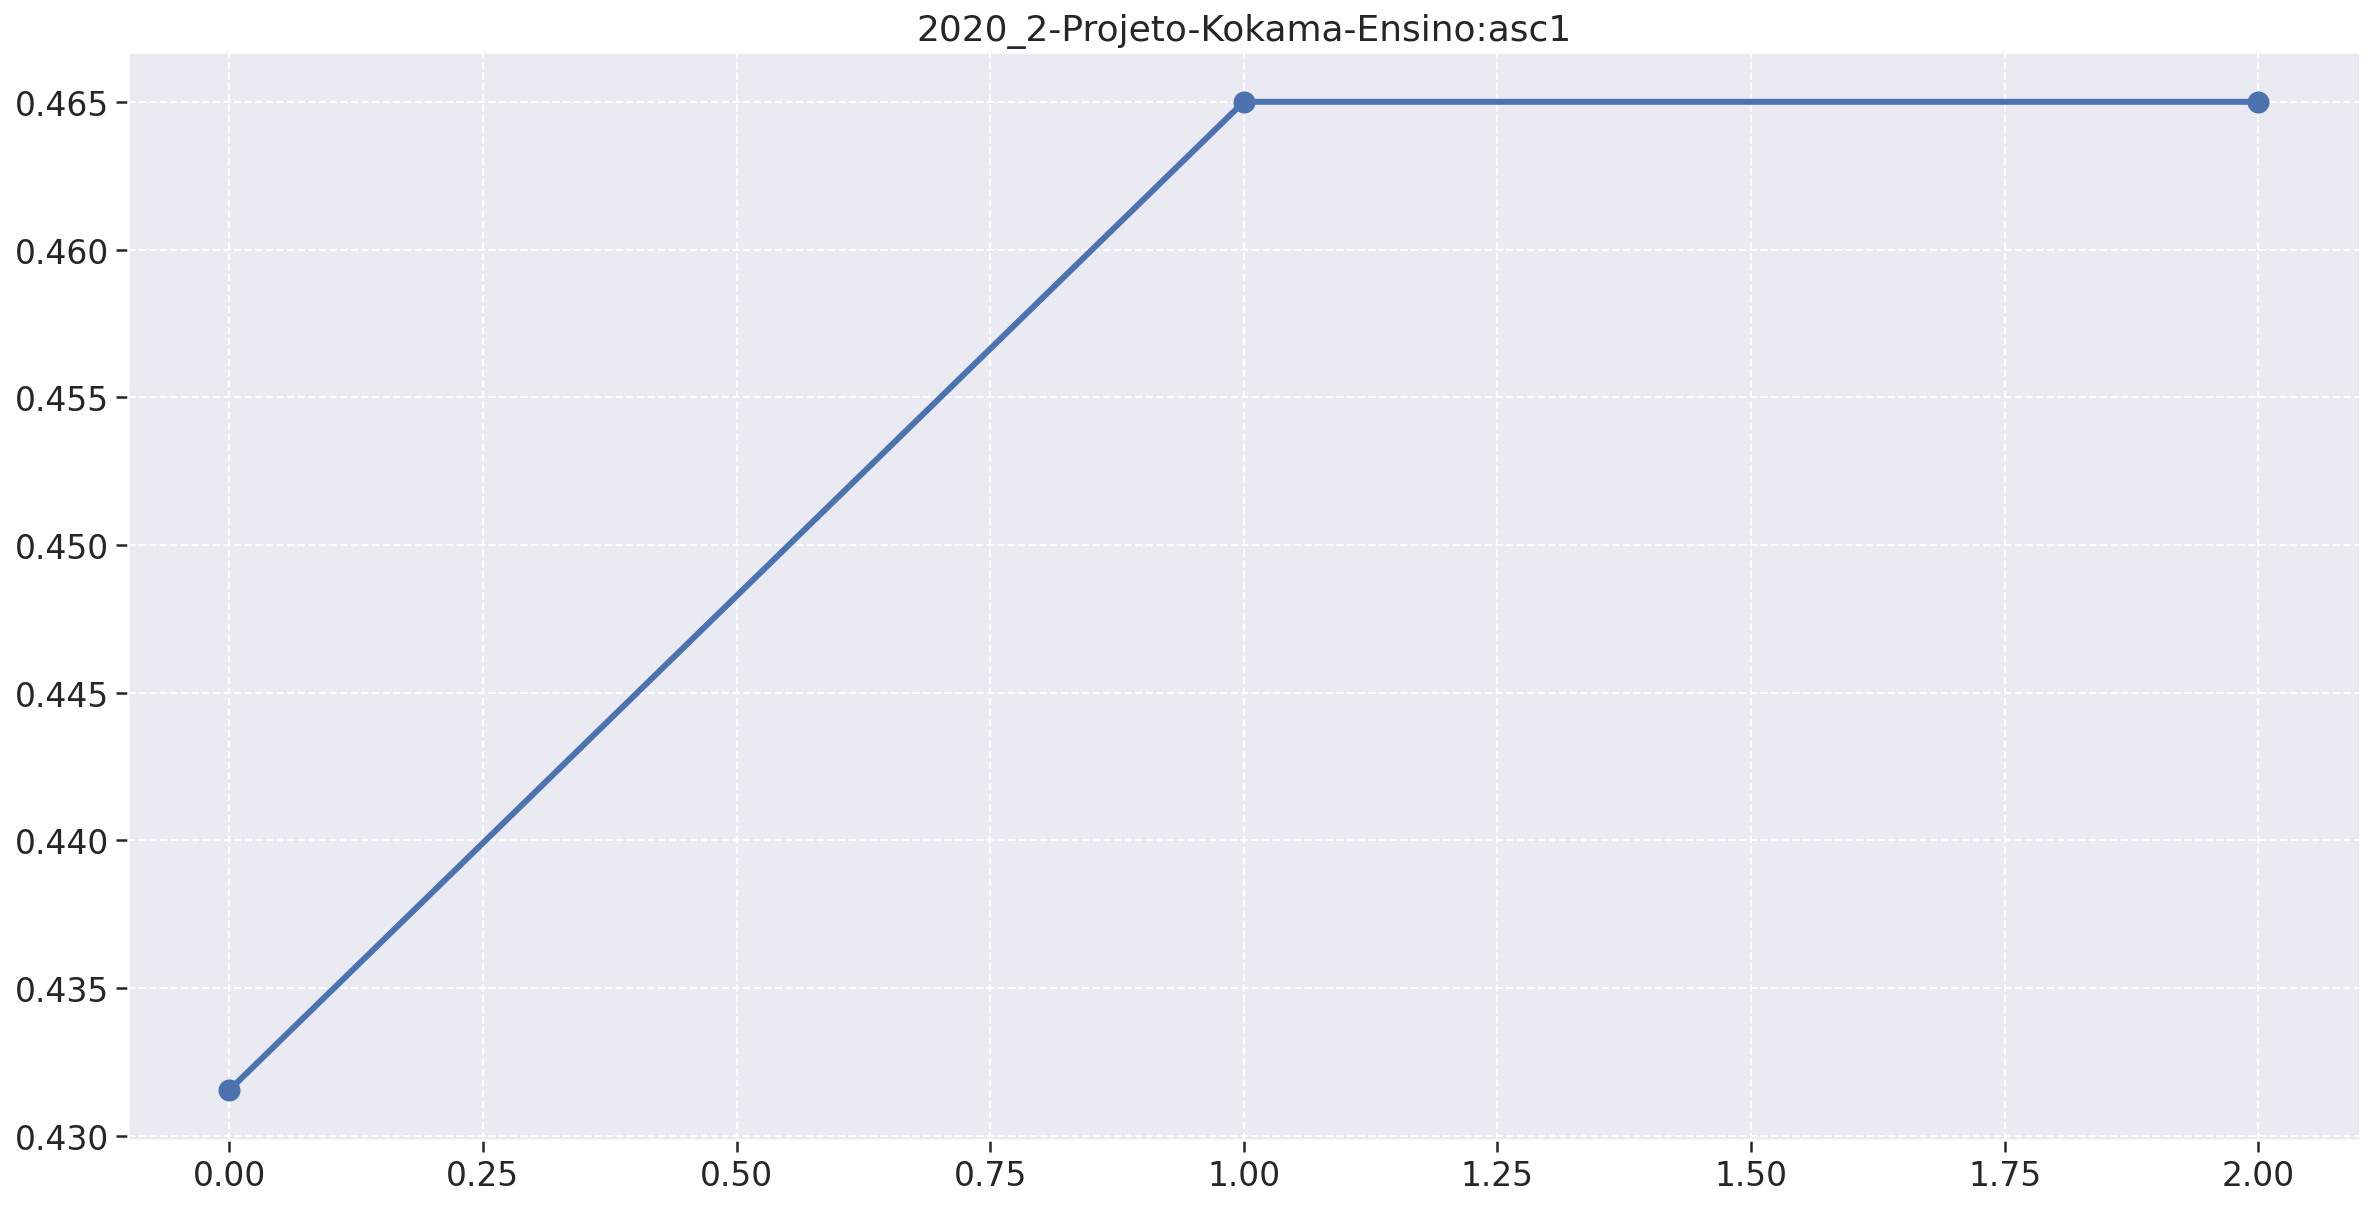

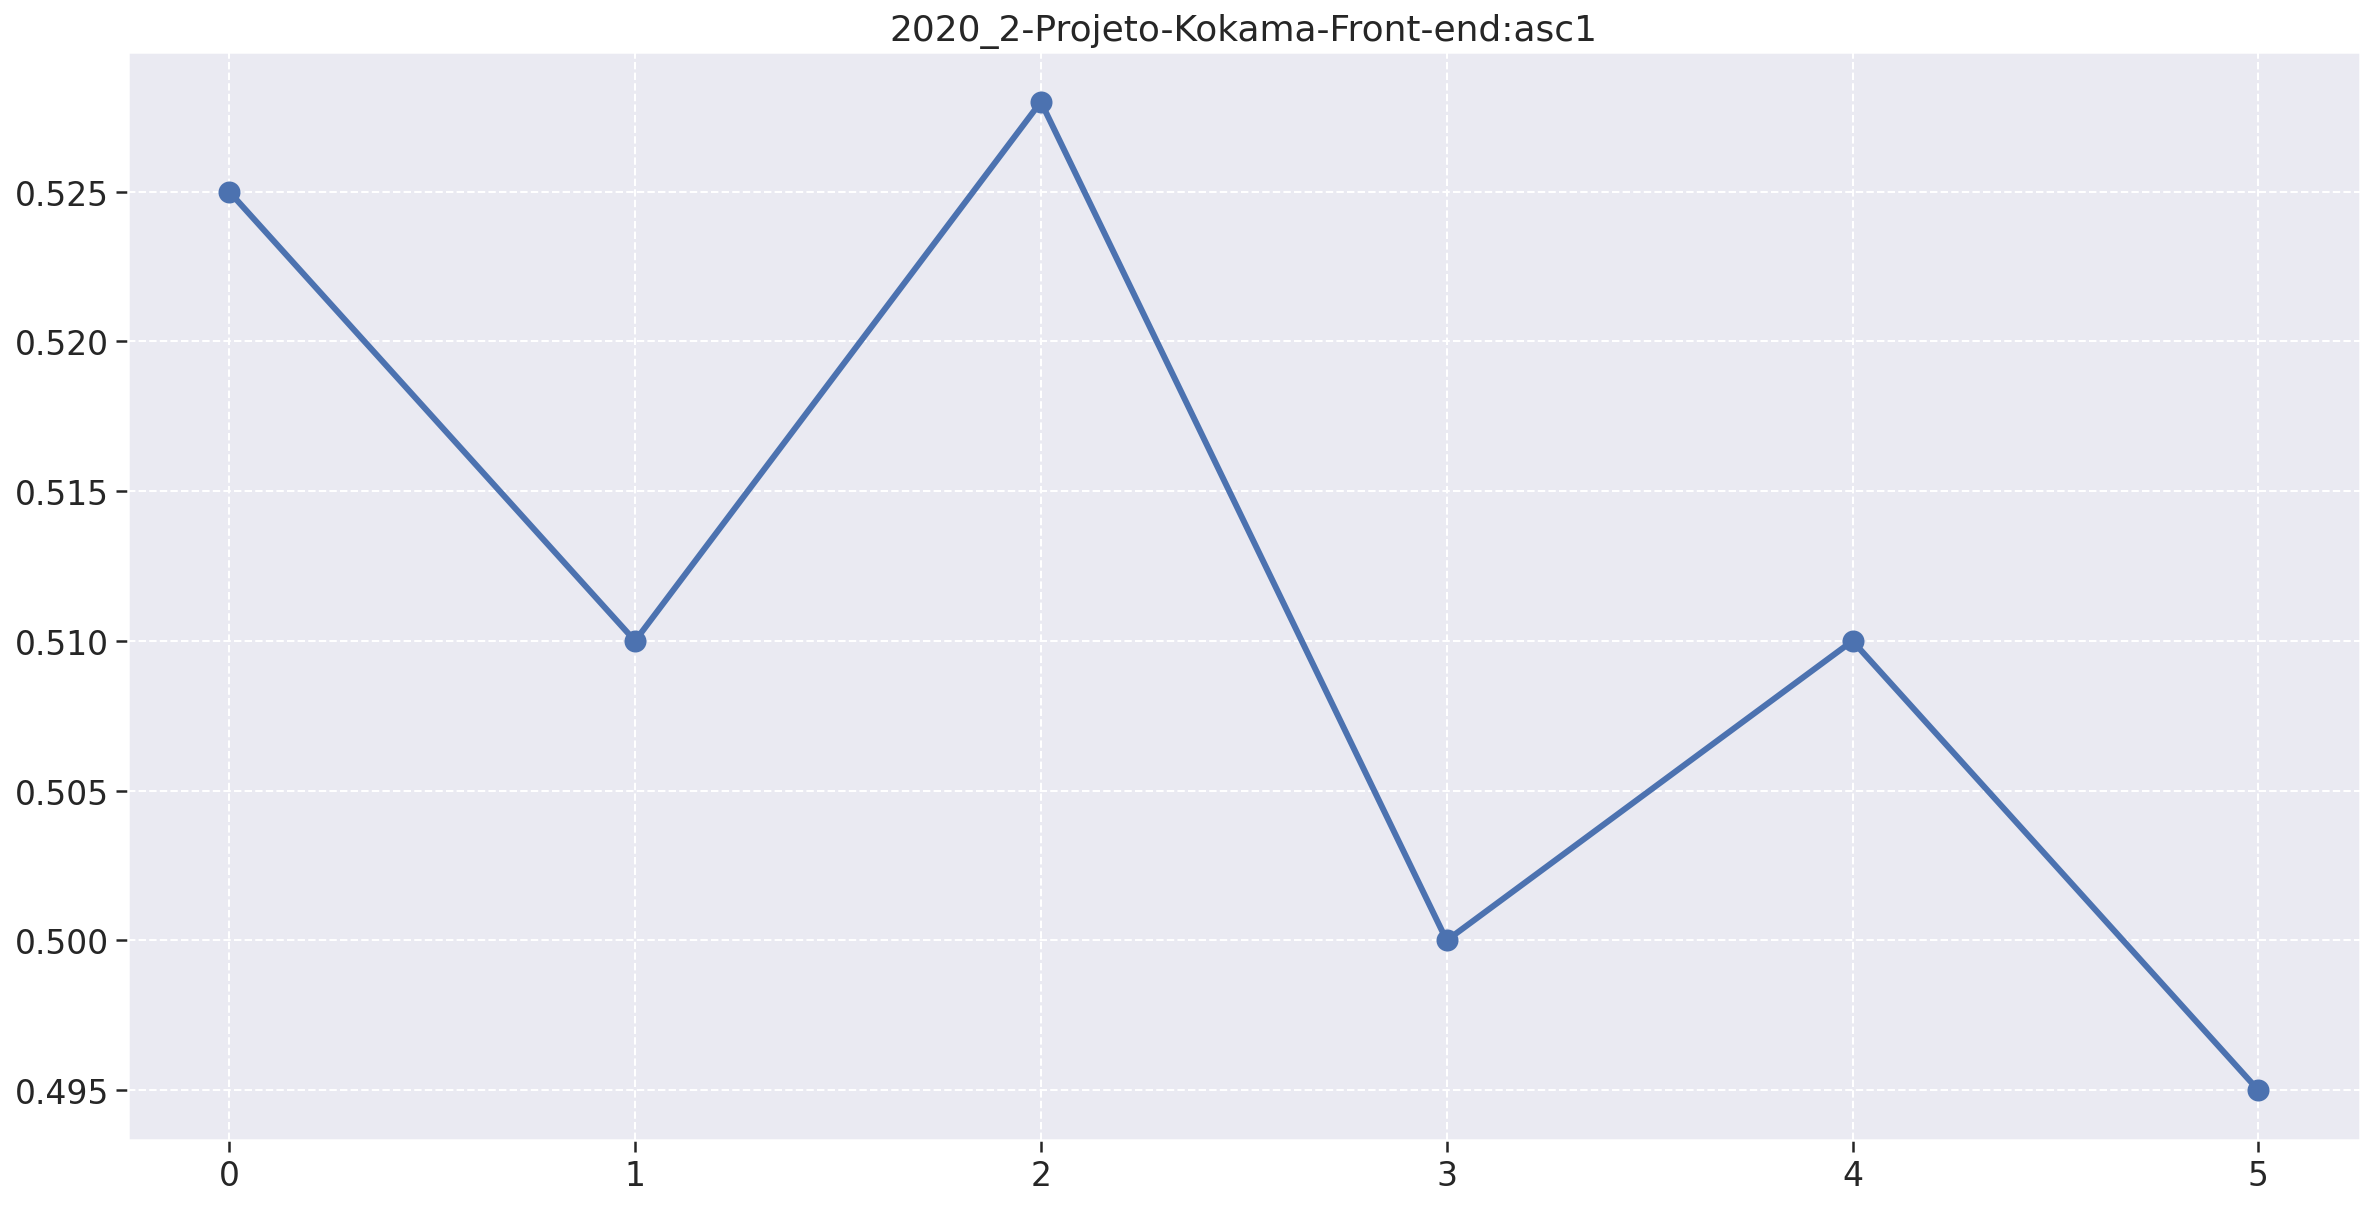

In [38]:
for repository, metrics_df in repository_metrics.items(): 
    fig = plt.figure(figsize=(20, 10))
    plt.title(f"{repository}:asc1")
    plt.plot(metrics_df['asc1'], linewidth=3, marker='o', markersize=10)

In [39]:
all_metrics_df = pd.DataFrame()

for repository, metrics_df in repository_metrics.items():
    all_metrics_df = pd.concat([all_metrics_df, metrics_df], ignore_index=True)

all_metrics_df['ac1'] = all_metrics_df['asc1'] * 1
all_metrics_df['total'] = all_metrics_df['asc1'] * 1

In [40]:
all_metrics_df

,m1,m2,m3,repository,version,ncloc,asc1,ac1,total
0,0.190476,0.095238,1.0,2020_2-Projeto-Kokama-Traducao,05-04-2021,465,0.424286,0.424286,0.424286
1,0.285714,0.142857,1.0,2020_2-Projeto-Kokama-Traducao,06-04-2021,308,0.471429,0.471429,0.471429
2,0.285714,0.142857,1.0,2020_2-Projeto-Kokama-Traducao,14-05-2021,330,0.471429,0.471429,0.471429
3,0.173913,0.086957,1.0,2020_2-Projeto-Kokama-Traducao,23-03-2021,336,0.416087,0.416087,0.416087
4,0.200000,0.080000,1.0,2020_2-Projeto-Kokama-Usuario,14-05-2021,570,0.422400,0.422400,0.422400
5,0.200000,0.080000,1.0,2020_2-Projeto-Kokama-Usuario,15-05-2021,531,0.422400,0.422400,0.422400
6,0.304348,0.130435,1.0,2020_2-Projeto-Kokama-Usuario,16-05-2021,687,0.473478,0.473478,0.473478
7,0.000000,0.000000,1.0,2020_2-Projeto-Kokama-Usuario,17-04-2021,24,0.330000,0.330000,0.330000
8,0.230769,0.076923,1.0,2020_2-Projeto-Kokama-Ensino,14-04-2021,371,0.431538,0.431538,0.431538
9,0.318182,0.090909,1.0,2020_2-Projeto-Kokama-Ensino,14-05-2021,332,0.465000,0.465000,0.465000


In [41]:
m7(NUMBER_OF_ISSUES_RESOLVED, NUMBER_OF_ISSUES)

94.07

In [42]:
m8(TAGS, NUMBER_OF_ISSUES)

,density,percentage
0,hotfix,0.74
1,docs,51.85
2,arq,5.93
3,devops,12.59
4,sm,25.19
5,po,9.63
6,da,4.44
7,analytics,5.93
8,us,12.59
9,ts,9.63


In [43]:
m9(TAGS, NUMBER_OF_ISSUES)

88.89

In [44]:
all_metrics_df.to_excel('data/metrics_df.xlsx', index = False)

In [45]:
# repo = '2020_2-Projeto-Kokama-Traducao'
# plt.title(repo)
# all_metrics_df['total'][(all_metrics_df['repository'] == repo)].hist().plot()

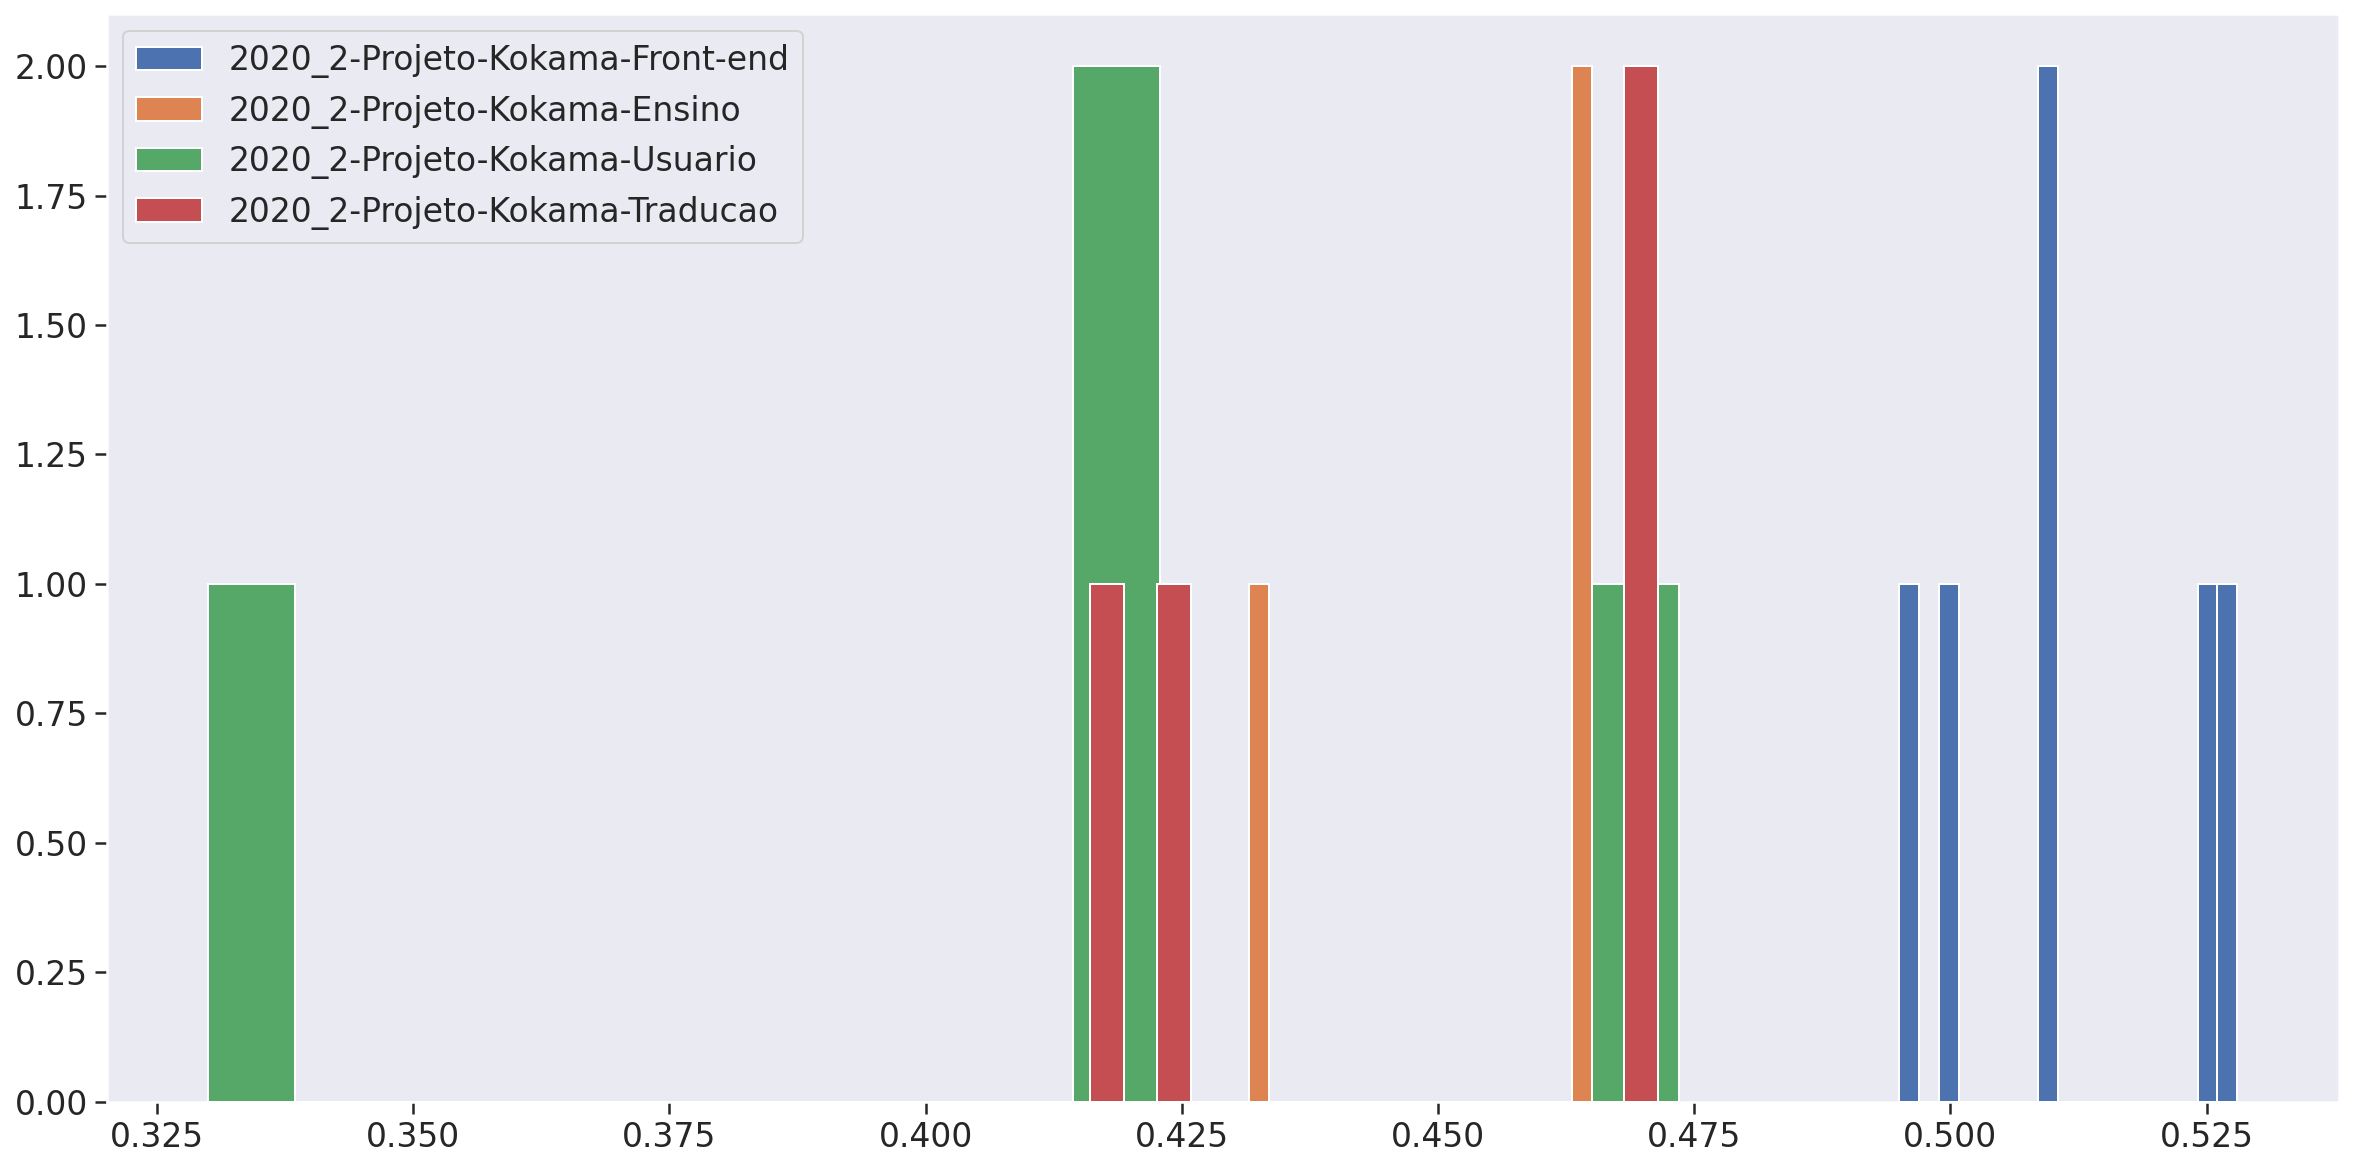

In [46]:
plt.figure(figsize=(20, 10))
for repo in repos[::-1]:
    plt.hist(all_metrics_df['total'][(all_metrics_df['repository'] == repo)], label=repo, bins=len(all_metrics_df['total']))

plt.grid()
plt.legend()
plt.show()

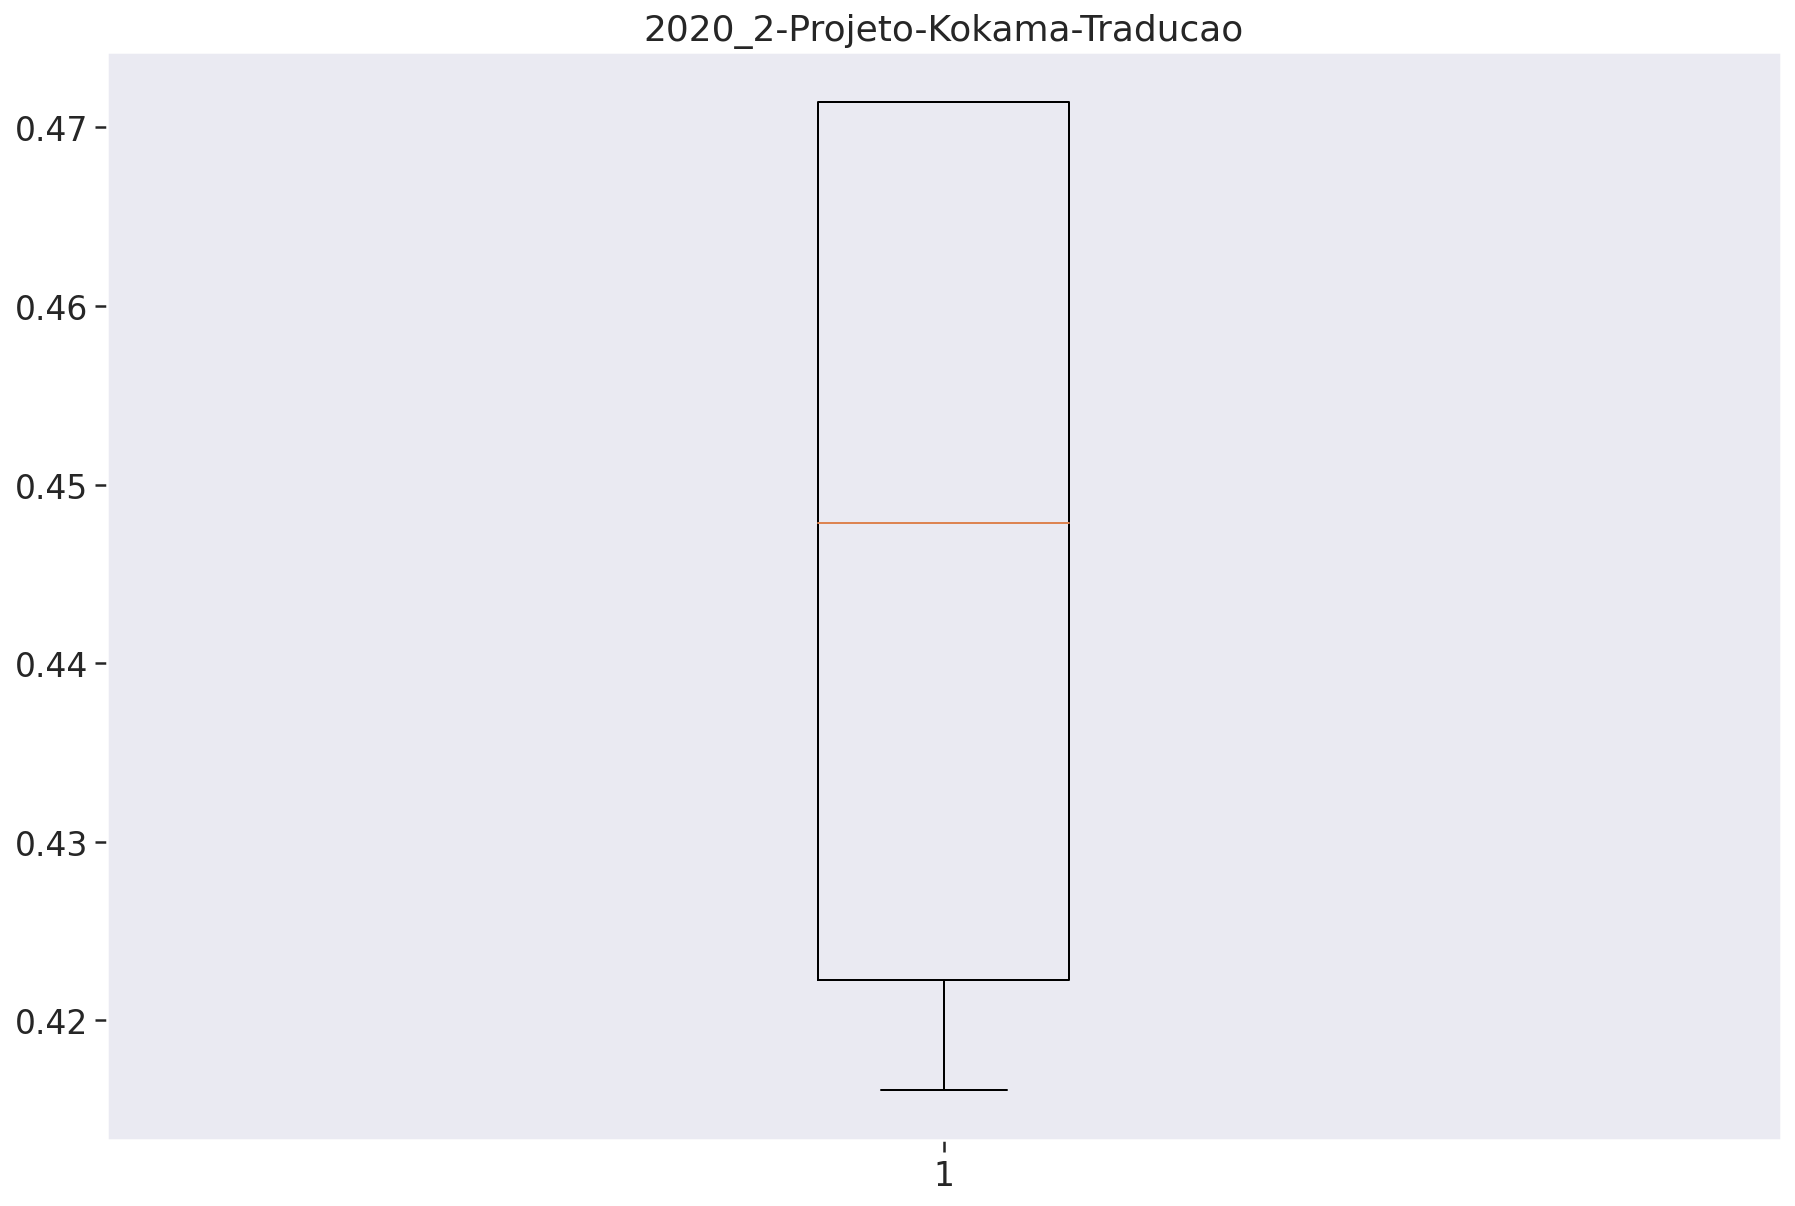

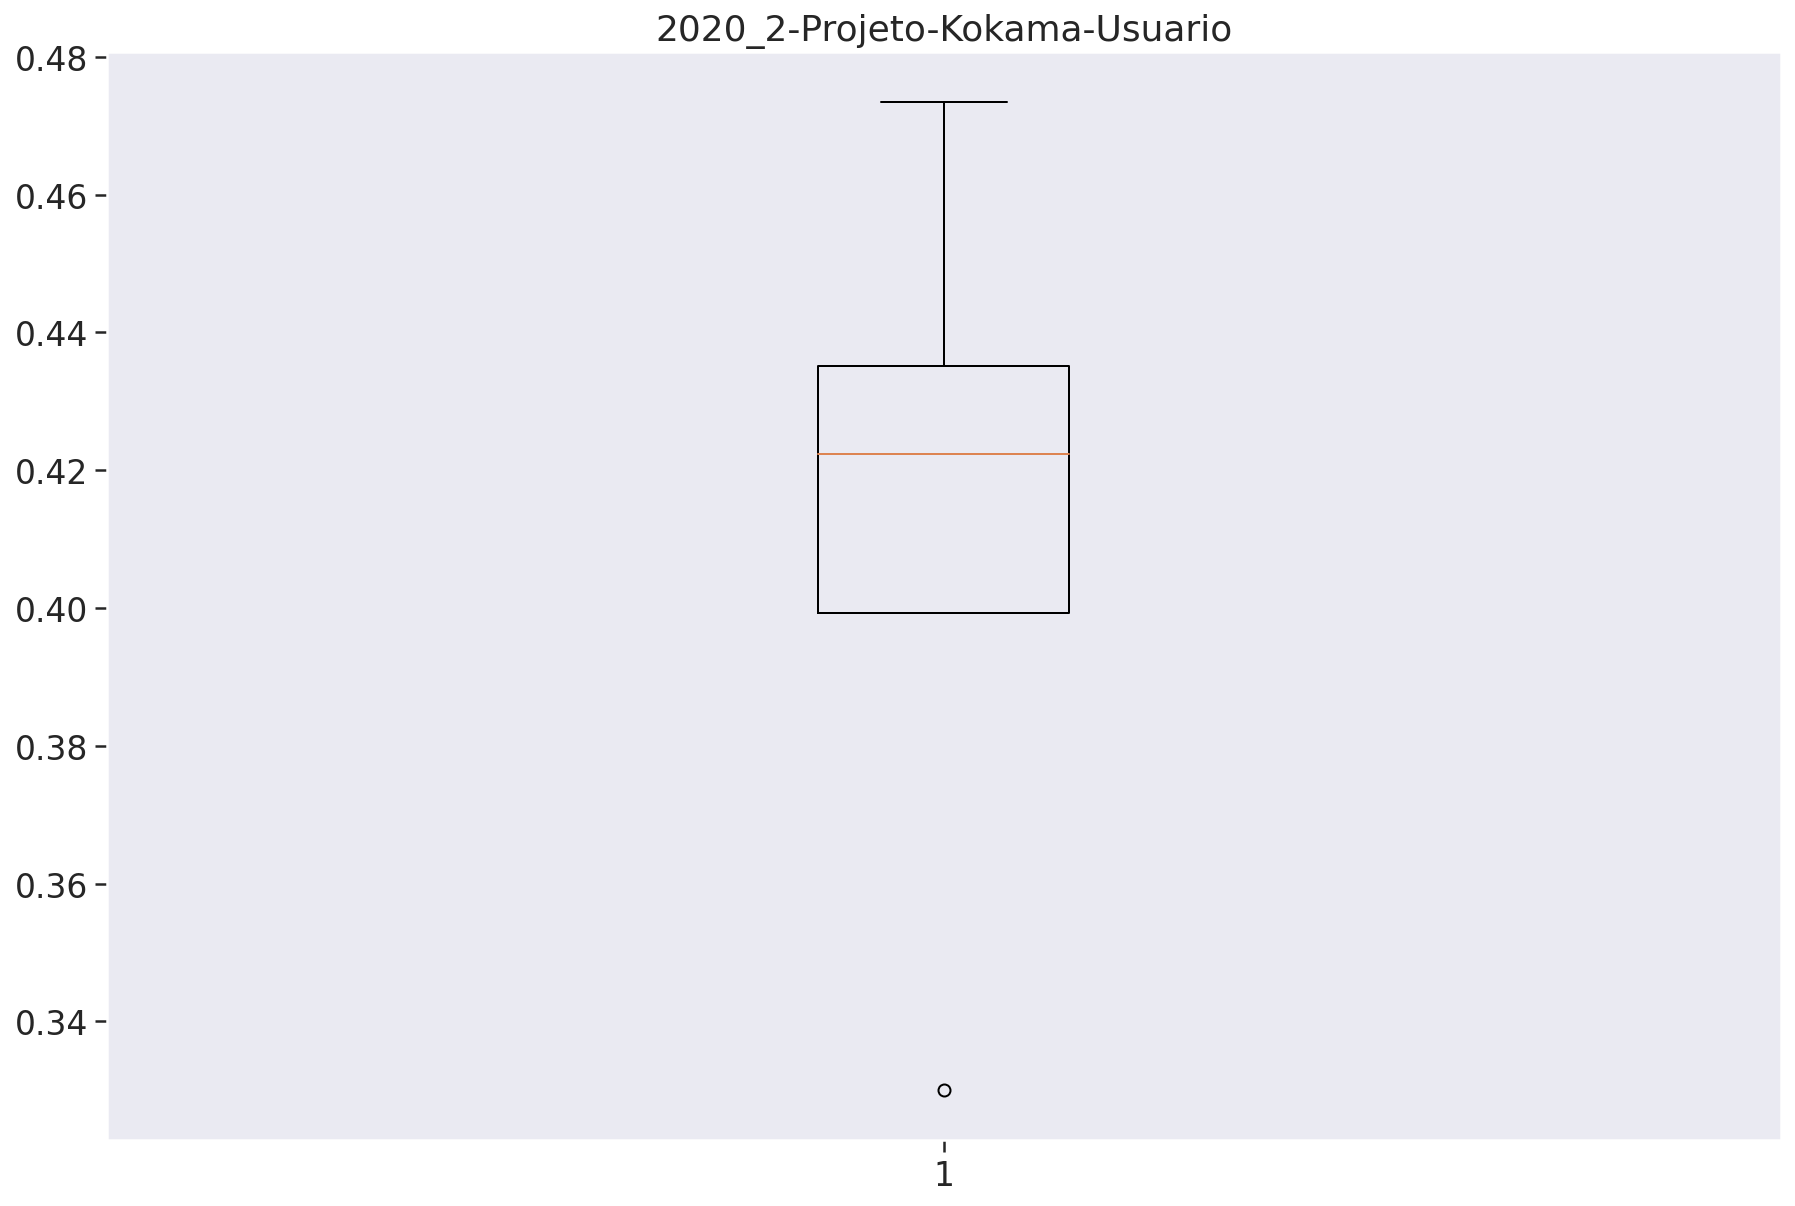

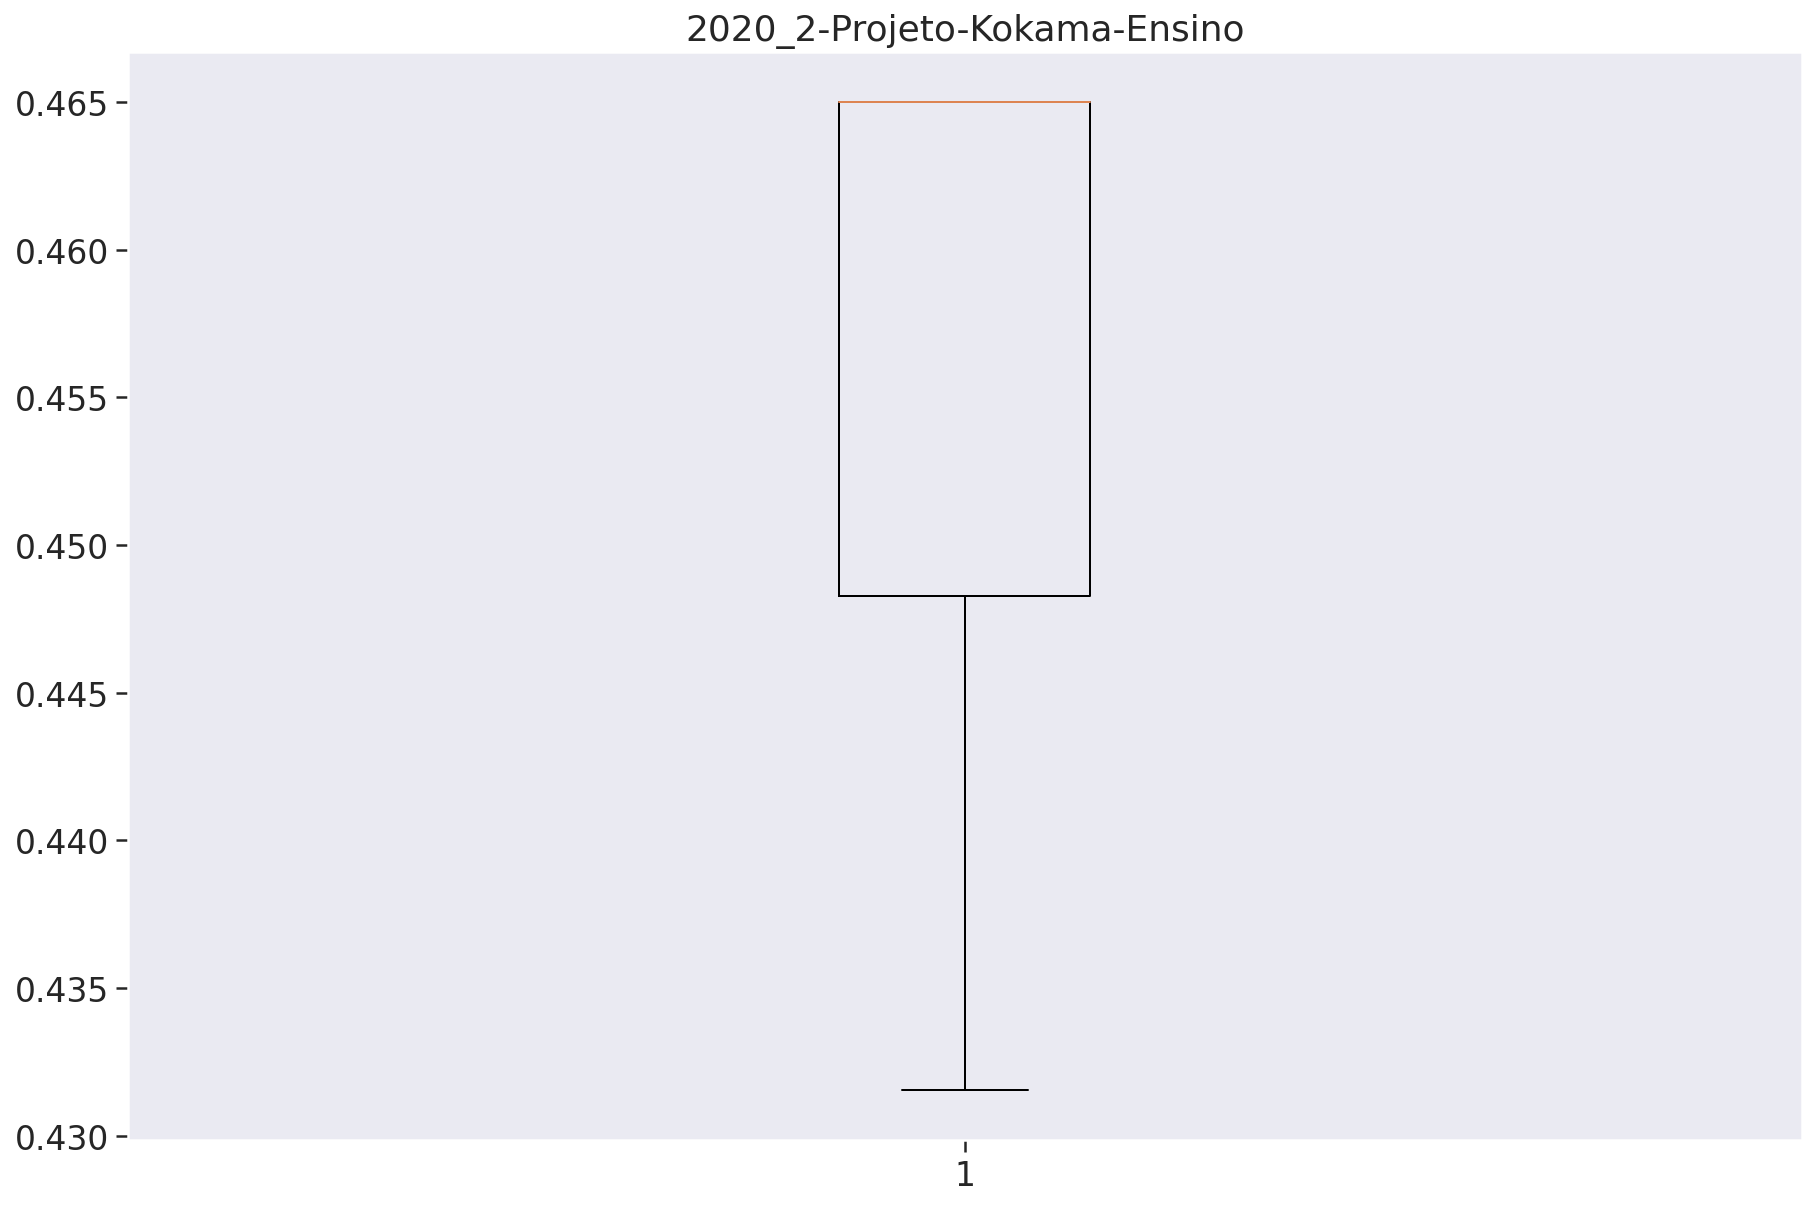

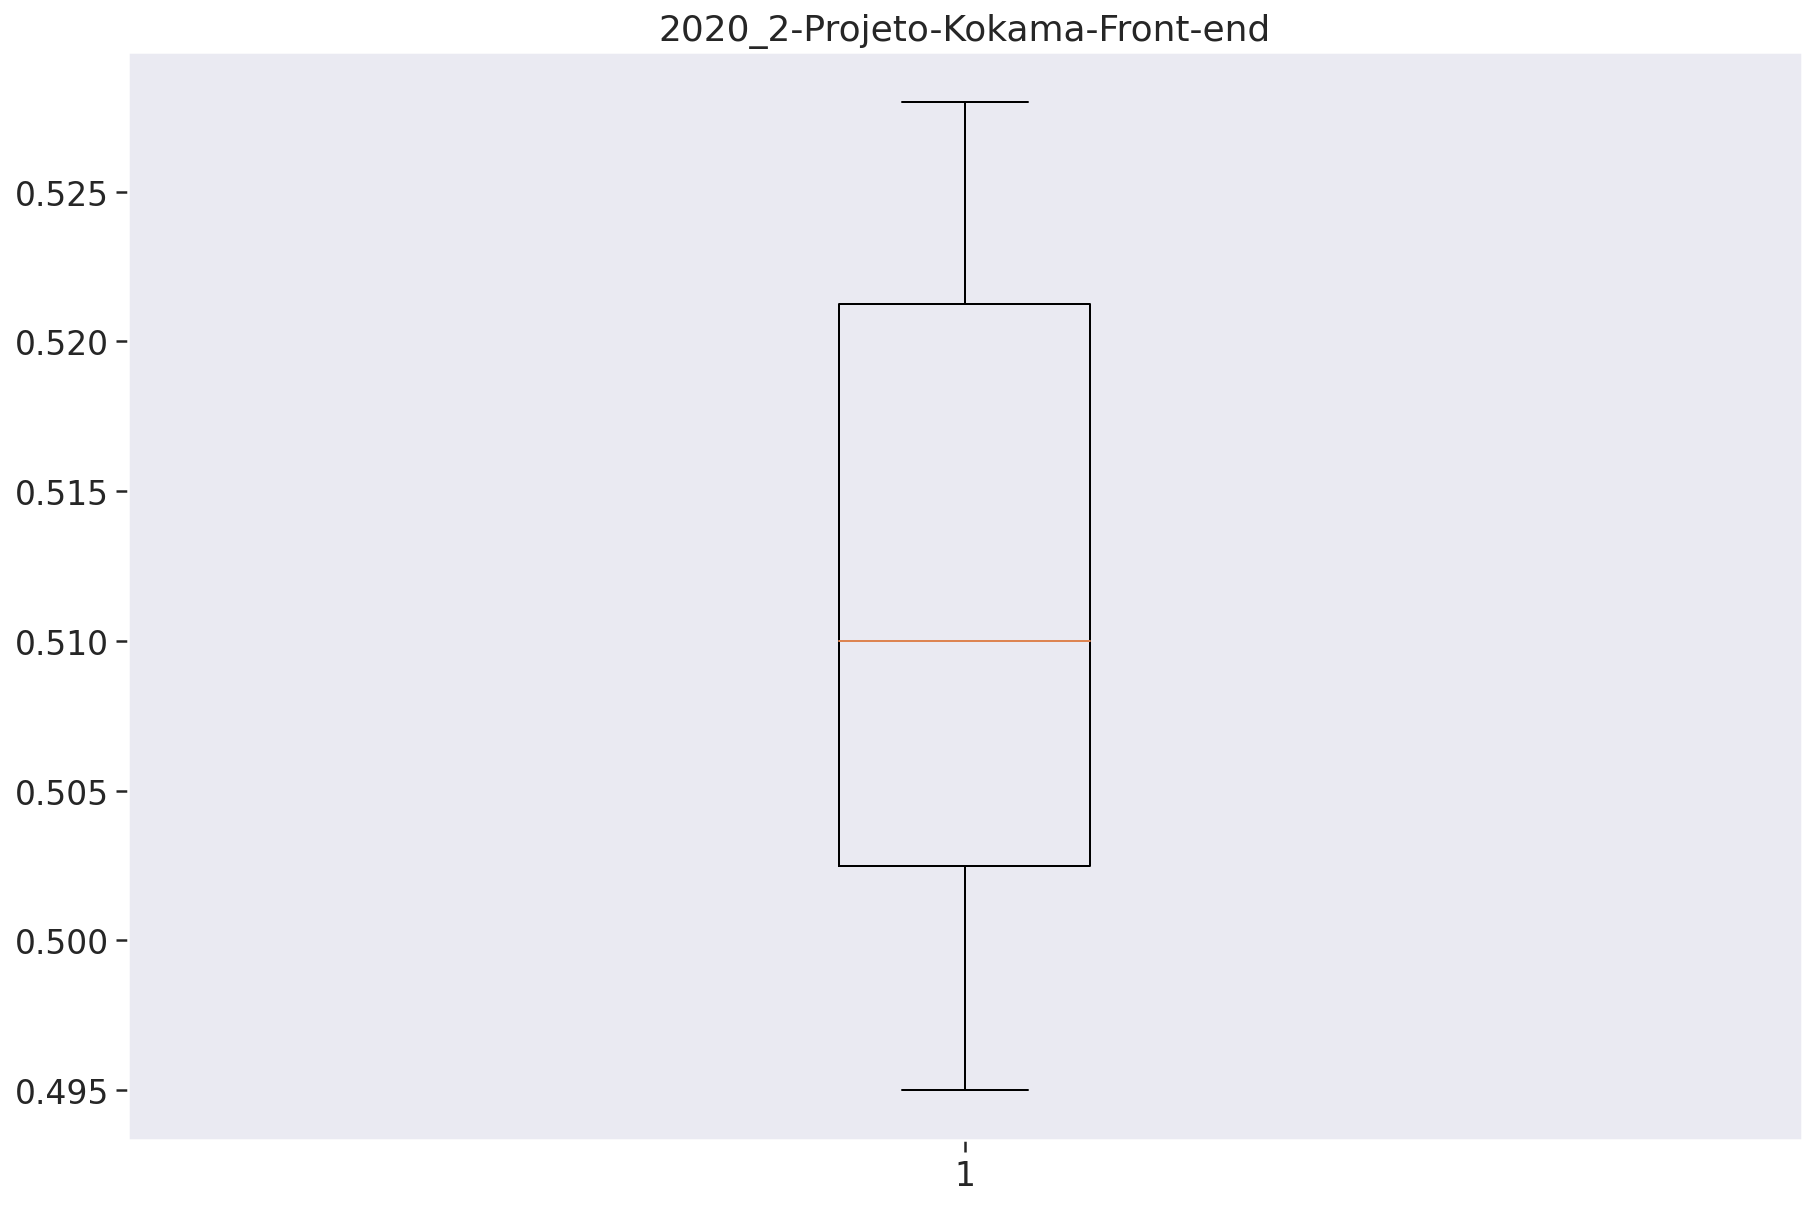

In [51]:
for repo in repos:
    plt.figure(figsize=(15, 10))
    plt.title(repo)
    plt.boxplot(all_metrics_df['total'][(all_metrics_df['repository'] == repo)])
    plt.grid()
    plt.show()

In [41]:
# NUMBER_OF_ISSUES_RESOLVED = 127


# #Adicionados SM, PO, DA; Substituido FEATURE por US e TS
# TAGS = {
#     "HOTFIX": 1,
#     "DOCS": 70,
#     "ARQ": 8,
#     "DEVOPS": 17,
#     "SM": 34,
#     "PO": 13,
#     "DA": 6,
#     "ANALYTICS": 8,
#     "US": 17,
#     "TS": 13,
#     "EASY": 18,
#     "MEDIUM": 20,
#     "HARD": 3,
#     "EPS": 83,
#     "MDS": 62
# }


In [57]:
NUMBER_OF_ISSUES = 127+8

tags = []
number_of_resolved_issues = []

# SPRINT 0

number_of_resolved_issues.append(8)

tags.append({
    "HOTFIX": 0,
    "DOCS": 7,
    "ARQ": 0,
    "DEVOPS": 1,
    "SM": 5,
    "PO": 1,
    "DA": 0,
    "ANALYTICS": 0,
    "US": 0,
    "TS": 0,
    "EASY": 0,
    "MEDIUM": 0,
    "HARD": 0,
    "EPS": 3,
    "MDS": 0
})
# SPRINT 1

number_of_resolved_issues.append(6)

tags.append({
    "HOTFIX": 0,
    "DOCS": 5,
    "ARQ": 0,
    "DEVOPS": 1,
    "SM": 2,
    "PO": 0,
    "DA": 0,
    "ANALYTICS": 0,
    "US": 0,
    "TS": 0,
    "EASY": 0,
    "MEDIUM": 0,
    "HARD": 0,
    "EPS": 5,
    "MDS": 2
})

# SPRINT 2

number_of_resolved_issues.append(9)

tags.append({
    "HOTFIX": 0,
    "DOCS": 9,
    "ARQ": 0,
    "DEVOPS": 1,
    "SM": 1,
    "PO": 1,
    "DA": 0,
    "ANALYTICS": 0,
    "US": 0,
    "TS": 0,
    "EASY": 0,
    "MEDIUM": 0,
    "HARD": 0,
    "EPS": 5,
    "MDS": 5
})

# SPRINT 3

number_of_resolved_issues.append(12)

tags.append({
    "HOTFIX": 0,
    "DOCS": 11,
    "ARQ": 2,
    "DEVOPS": 1,
    "SM": 4,
    "PO": 3,
    "DA": 0,
    "ANALYTICS": 0,
    "US": 0,
    "TS": 0,
    "EASY": 0,
    "MEDIUM": 0,
    "HARD": 0,
    "EPS": 9,
    "MDS": 8
})

# SPRINT 4

number_of_resolved_issues.append(13)

tags.append({
    "HOTFIX": 0,
    "DOCS": 5,
    "ARQ": 1,
    "DEVOPS": 2,
    "SM": 3,
    "PO": 1,
    "DA": 0,
    "ANALYTICS": 0,
    "US": 2,
    "TS": 0,
    "EASY": 0,
    "MEDIUM": 0,
    "HARD": 0,
    "EPS": 11,
    "MDS": 3
})

# SPRINT 5

number_of_resolved_issues.append(7)

tags.append({
    "HOTFIX": 0,
    "DOCS": 3,
    "ARQ": 1,
    "DEVOPS": 1,
    "SM": 2,
    "PO": 1,
    "DA": 1,
    "ANALYTICS": 0,
    "US": 1,
    "TS": 1,
    "EASY": 0,
    "MEDIUM": 0,
    "HARD": 0,
    "EPS": 4,
    "MDS": 2
})

# SPRINT 6

number_of_resolved_issues.append(13)

tags.append({
    "HOTFIX": 0,
    "DOCS": 10,
    "ARQ": 1,
    "DEVOPS": 1,
    "SM": 2,
    "PO": 0,
    "DA": 0,
    "ANALYTICS": 0,
    "US": 1,
    "TS": 0,
    "EASY": 0,
    "MEDIUM": 0,
    "HARD": 0,
    "EPS": 8,
    "MDS": 7
})


# SPRINT 7

number_of_resolved_issues.append(6)

tags.append({
    "HOTFIX": 0,
    "DOCS": 3,
    "ARQ": 0,
    "DEVOPS": 1,
    "SM": 2,
    "PO": 1,
    "DA": 1,
    "ANALYTICS": 0,
    "US": 1,
    "TS": 0,
    "EASY": 0,
    "MEDIUM": 0,
    "HARD": 0,
    "EPS": 3,
    "MDS": 3,
})


# SPRINT 8

number_of_resolved_issues.append(10)

tags.append({
    "HOTFIX": 0,
    "DOCS":3,
    "ARQ": 1,
    "DEVOPS": 1,
    "SM": 3,
    "PO": 0,
    "DA": 1,
    "ANALYTICS": 0,
    "US": 0,
    "TS": 0,
    "EASY": 5,
    "MEDIUM": 4,
    "HARD": 0,
    "EPS": 5,
    "MDS": 6
})

# SPRINT 09

number_of_resolved_issues.append(8)

tags.append({
    "HOTFIX": 1,
    "DOCS": 2,
    "ARQ": 0,
    "DEVOPS": 3,
    "SM": 2,
    "PO": 0,
    "DA": 0,
    "ANALYTICS": 3,
    "US": 1,
    "TS": 0,
    "EASY": 4,
    "MEDIUM": 3,
    "HARD": 1,
    "EPS": 6,
    "MDS": 2
})

# SPRINT 10

number_of_resolved_issues.append(6)

tags.append({
    "HOTFIX": 0,
    "DOCS": 2,
    "ARQ": 1,
    "DEVOPS": 2,
    "SM": 2,
    "PO": 1,
    "DA": 0,
    "ANALYTICS": 0,
    "US": 1,
    "TS": 0,
    "EASY": 4,
    "MEDIUM": 2,
    "HARD": 0,
    "EPS": 5,
    "MDS": 1
})

# SPRINT 11

number_of_resolved_issues.append(7)

tags.append({
    "HOTFIX": 0,
    "DOCS": 4,
    "ARQ": 0,
    "DEVOPS": 0,
    "SM": 4,
    "PO": 3,
    "DA": 0,
    "ANALYTICS": 1,
    "US": 0,
    "TS": 2,
    "EASY": 4,
    "MEDIUM": 2,
    "HARD": 1,
    "EPS": 5,
    "MDS": 2
})

# SPRINT 12

number_of_resolved_issues.append(4)

tags.append({
    "HOTFIX": 0,
    "DOCS": 2,
    "ARQ": 0,
    "DEVOPS": 1,
    "SM": 0,
    "PO": 0,
    "DA": 0,
    "ANALYTICS": 12,
    "US": 1,
    "TS": 2,
    "EASY": 2,
    "MEDIUM": 3,
    "HARD": 0,
    "EPS": 2,
    "MDS": 2,
})
# SPRINT 13

number_of_resolved_issues.append(4)

tags.append({
    "HOTFIX": 0,
    "DOCS": 0,
    "ARQ": 0,
    "DEVOPS": 0,
    "SM": 0,
    "PO": 0,
    "DA": 0,
    "ANALYTICS": 0,
    "US": 1,
    "TS": 3,
    "EASY": 0,
    "MEDIUM": 3,
    "HARD": 0,
    "EPS": 0,
    "MDS": 4,
})
# SPRINT 14

number_of_resolved_issues.append(2)

tags.append({
    "HOTFIX": 0,
    "DOCS": 2,
    "ARQ": 0,
    "DEVOPS": 0,
    "SM": 0,
    "PO": 0,
    "DA": 1,
    "ANALYTICS": 1,
    "US": 0,
    "TS": 0,
    "EASY": 0,
    "MEDIUM": 1,
    "HARD": 1,
    "EPS": 2,
    "MDS": 2,
})


In [58]:
def m7(number_of_issues_resolved, number_of_issues):
    
    resolved_issues_throughput = round((number_of_issues_resolved / number_of_issues) * 100, 2)
    
    return resolved_issues_throughput

In [59]:
def density(issue, number_of_issues):
    issue_density = round((issue / number_of_issues) * 100, 2)
    return issue_density


In [60]:
def m8(tag_dict, number_of_issues):
    
    issue_densities = {
        "hotfix": [density(tag_dict["HOTFIX"], number_of_issues)],
        "docs": [density(tag_dict["DOCS"], number_of_issues)],
        "arq": [density(tag_dict["ARQ"], number_of_issues)],
        "devops": [density(tag_dict["DEVOPS"], number_of_issues)],
        "sm": [density(tag_dict["SM"], number_of_issues)],
        "po": [density(tag_dict["PO"], number_of_issues)],
        "da": [density(tag_dict["DA"], number_of_issues)],
        "analytics": [density(tag_dict["ANALYTICS"], number_of_issues)],
        "us": [density(tag_dict["US"], number_of_issues)],
        "ts": [density(tag_dict["TS"], number_of_issues)],
        "easy": [density(tag_dict["EASY"], number_of_issues)],
        "medium": [density(tag_dict["MEDIUM"], number_of_issues)],
        "hard": [density(tag_dict["HARD"], number_of_issues)],
        "eps": [density(tag_dict["EPS"], number_of_issues)],
        "mds": [density(tag_dict["MDS"], number_of_issues)]
    }

    issue_densities = pd.DataFrame.from_dict(issue_densities).T.reset_index()
    
    issue_densities.columns = ['density' ,'percentage']
    
    return issue_densities

In [61]:
def m9(tag_dict, number_of_issues):
    #Substituido FEATURE por US
    bugs_ratio = round(((tag_dict["DOCS"] + tag_dict["US"] + tag_dict["ARQ"] + tag_dict["DEVOPS"] + tag_dict["ANALYTICS"]) / number_of_issues) * 100, 2)
    
    return bugs_ratio

In [62]:
# _m7 = m7(NUMBER_OF_ISSUES_RESOLVED, NUMBER_OF_ISSUES)
# _m8 = m8(TAGS, NUMBER_OF_ISSUES)
# _m9 = m9(TAGS, NUMBER_OF_ISSUES)

In [ ]:
from datetime import *

data_inicio_list = []
data_fim_list = []

inicio0 = datetime.datetime(2021, 2, 4)
inicio1 = inicio0 + timedelta (days=10)

# inicio sprint 0
data_inicio_list.append(inicio0)
# inicio sprint 1
data_inicio_list.append(inicio1)

# fim sprint 0
data_fim_list.append(inicio1)

for i in range(14):
    inicio1 = inicio1 + timedelta (days=7)
    # fim sprint 1
    data_fim_list.append(inicio1)
    # inicio sprint 2
    data_inicio_list.append(inicio1)
    
print len

In [68]:


m7_list = []
m9_list = []
asc2_list = []
sprint_list = []

for i in range(len(tags)):
    m7_list.append(m7(number_of_resolved_issues[i], NUMBER_OF_ISSUES))
    m9_list.append(m9(tags[i], NUMBER_OF_ISSUES))
    asc2_list.append((m7_list[i]+m9_list[i])/2)
    sprint_list.append(i)
    
new_metrics_df = pd.DataFrame({
#     'data_inicio': 
#     'data_fim':
    'm7': m7_list,
    'm9': m9_list,
    'asc2': asc2_list,
    'totalAC2': asc2_list,
    'no_sprint': sprint_list
})

new_metrics_df

,m7,m9,asc2,totalAC2,no_sprint
0,5.93,5.93,5.930,5.930,0
1,4.44,4.44,4.440,4.440,1
2,6.67,7.41,7.040,7.040,2
3,8.89,10.37,9.630,9.630,3
4,9.63,7.41,8.520,8.520,4
5,5.19,4.44,4.815,4.815,5
6,9.63,9.63,9.630,9.630,6
7,4.44,3.70,4.070,4.070,7
8,7.41,3.70,5.555,5.555,8
9,5.93,6.67,6.300,6.300,9
